<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/claudiamarcelacaro/Maestria_IA/blob/main/Disenio_software_inteligente/Proyecto_Deep_Learning_Claudia_Marcela_Caro_Cortes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"/></a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/claudiamarcelacaro/Maestria_IA/blob/main/Disenio_software_inteligente/Proyecto_Deep_Learning_Claudia_Marcela_Caro_Cortes.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Abrir en Kaggle" title="Abrir y ejecutar en Kaggle"/></a>
  </td>
</table>

# Proyecto Diseño de Software Inteligente

**Name:** Claudia Marcela Caro Cortés <br>
**E-mail:** claudia.caro01@usa.edu.co <br>
[Github](https://github.com/claudiamarcelacaro).

**Conjunto de datos seleccionado:** *IBM HR Analytics Employee Attrition & Performance*

In [317]:
#!pip install -U imbalanced-learn
#!pip install -U scikit-learn==1.2.0
#!pip install PyQt5

In [318]:
#import sys
#from PyQt5.QtWidgets import *
#import os
#import tensorflow as tf
#import keras
#os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
#os.environ['TF_KERAS'] = '1'
#os.environ["NVIDIA GeForce RTX 3060 Laptop GPU"] = "0"

In [319]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import pylab as pl
from zipfile import ZipFile
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #validar los datos imbalanceados
from sklearn.decomposition import PCA # (análisis para componentes principales) fusiona las características para la exploración de datos, metodo no supervisado
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from pylab import rcParams

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter #ayuda a contar clases

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Attrition"]

%matplotlib inline

## Utilidades

In [320]:
def load_employee_data():
    tarball_path = Path("datasets/IBM_HR_Employee.zip")
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://raw.githubusercontent.com/claudiamarcelacaro/Maestria_IA/main/Disenio_software_inteligente/ibm-hr-analytics-attrition-dataset/IBM_HR_Employee.zip"
    urllib.request.urlretrieve(url, tarball_path)

    with ZipFile(tarball_path, 'r') as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/WA_Fn-UseC_-HR-Employee-Attrition.csv"))

employee = load_employee_data()

In [321]:
def table_df(columna,X): 
    feature = X.groupby(columna).agg({'Attrition':['size', 'sum', 'mean']})
    feature.columns = [' '.join(col).strip() for col in feature.columns.values]
    feature = feature.reset_index()
    feature['Attrition mean'] = feature['Attrition mean']*100
    feature.columns = [columna, f"Total {X[columna].name}", '# Deserción Laboral(Attrition)', 
                       '% de Deserción Laboral(Attrition) en el grupo relevante'] 
    feature['% de Deserción Laboral en la Compañia'] = (feature['# Deserción Laboral(Attrition)'] / 237)*100
        
    return feature

In [322]:
#crea la gráfica de barras horizontal
def graph_df(columna, X, y = 'bar', z = 0):
    feature = X.groupby(columna).agg({'Attrition':['size', 'sum', 'mean']})
    feature.columns = [' '.join(col).strip() for col in feature.columns.values]
    feature = feature.reset_index()
    feature['Attrition mean'] = feature['Attrition mean']*100
    feature.columns = [columna, 'Total Empleados', 'Attrition Number', 
                       '% de Deserción Laboral en el grupo relevante'] 
    
    fig0, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    feature.set_index(feature[columna], drop=True, inplace=True)
    feature['Total Empleados'].plot(kind = y, stacked = True, ax = ax1, 
                                   colormap = 'winter', rot = z)
    feature['% de Deserción Laboral en el grupo relevante'].plot(use_index = False, 
                                                         kind = 'line', ax = ax2, colormap='Spectral')
    plt.title('Deserción Laboral comparado con' + " Grupo" + " " + columna)
    ax1.set_xlabel(columna)
    ax1.yaxis.label.set_color('blue')
    ax1.set_ylabel("Total Empleados")
    ax2.set_ylabel("% Attrition en el grupo relevante")
    ax2.yaxis.label.set_color('red')
    plt.tight_layout()
    plt.show()

In [323]:
# código extra - código para guardar las figuras como PNG de alta resolución para el libro

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [324]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color.reshape(1,-1),
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def plot_labels(n_folds, n_classes, list_labels):
    ind = np.arange(n_folds)
    width = 0.15
    
    countings = []
    for labels in list_labels:
        labels = np.array(labels)
        countings.append([np.count_nonzero(labels == x) for x in range(n_classes)])
    
    class_bars = []
    for cls in range(n_classes):
        class_bars.append([l[cls] for l in countings])
    
    fig, ax = pl.subplots()
    i = 0
    for class_bar in class_bars:
        ax.bar(ind + width*i, class_bar, width, label='Clase '+str(i))
        i += 1
        
    ax.set_xticks(ind + 2*width / 3)
    ax.set_xticklabels(['Pliegue {}'.format(k) for k in range(n_folds)])
    pl.legend(loc="best")
    pl.title("Etiquetas")

## Comprender los datos

In [325]:
employee.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [326]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

* Hay 1470 instancias del conjunto de datos, no posee valores nulos. Posee 34 atributos de los cuales 26 son numéricos y 8 son de texto. <br>

* La variable objetivo con la que se va a trabajar es: "Attrition"

* El dataset está desbalanceado

In [327]:
employee["Attrition"].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [328]:
employee["Attrition"].name

'Attrition'

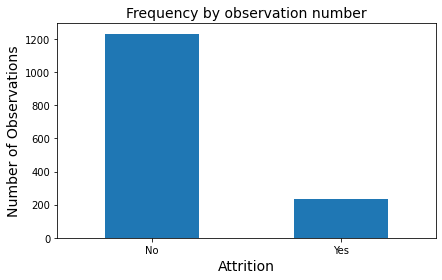

In [329]:
count_attrion = pd.value_counts(employee["Attrition"], sort = True)
count_attrion.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Attrition") #deserción laboral
save_fig("attrition_unbalanced")  # extra code
plt.ylabel("Number of Observations");

In [330]:
(1233 - 237) / 1233

0.8077858880778589

En el set de datos se observa muy pocos datos donde se registre la deserción laboral.

In [331]:
normal_df = employee[employee.Attrition == 'Yes'] # guardar las observaciones de normal_df en un df separado
attrition_df = employee[employee.Attrition == 'No']  # hacer lo mismo con las deserciones laborales

* Análisis comparativo normalizado entre las variables del dataset y su relación con la deserción laboral

In [332]:
#Reasignando valor
employee['Attrition'] = employee['Attrition'].apply(lambda x: 0 if x == 'No' else 1)

In [333]:
df2 = employee.copy()

In [334]:
#Age
table_df(columna = 'Age', X = df2)
bins = [17, 21, 25, 35, 60]
group_names = ['(18-21)', '(22-25)', '(26-35)', '(36-60)']
df2['Age'] = pd.cut(employee['Age'], bins, labels = group_names)
table_df(columna = 'Age', X = df2)

,Age,Total Age,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,(18-21),41,22,53.658537,9.282700
1,(22-25),82,22,26.829268,9.282700
2,(26-35),606,116,19.141914,48.945148
3,(36-60),741,77,10.391363,32.489451


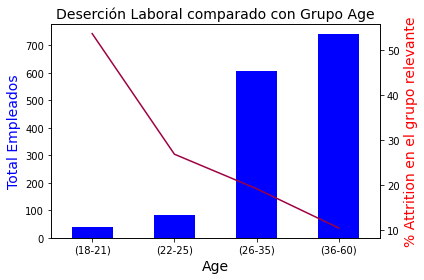

In [335]:
# Deserción Laboral comparada con el grupo de Edades
graph_df(columna = 'Age', X = df2)

El mayor porventaje de deserción laboral se presenta en la población de 18-21 años con el 53.66%, la deserción disminuye con el paso de los años.

In [336]:
#BusinessTravel
table_df(columna = 'BusinessTravel', X = df2)
table_df(columna = 'BusinessTravel', X = df2)

,BusinessTravel,Total BusinessTravel,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Non-Travel,150,12,8.000000,5.063291
1,Travel_Frequently,277,69,24.909747,29.113924
2,Travel_Rarely,1043,156,14.956855,65.822785


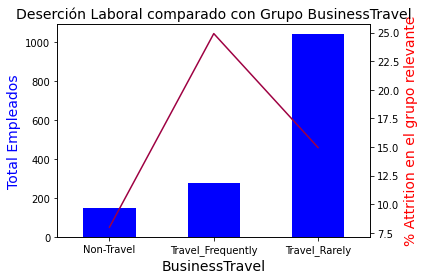

In [337]:
# Deserción Laboral comparada con el grupo de viaje de negocios
graph_df(columna = 'BusinessTravel', X = df2)

La mayor deserción se da en el grupo de trabajadores Viajeros Frecuentes con el 24.90%

In [338]:
#DailyRate
table_df(columna = 'DailyRate', X = df2)
bins = [1, 500, 1000, 1500]
group_names = ['(1-500)', '(501-1000)', '(1001-1500)']
df2['DailyRate'] = pd.cut(employee['DailyRate'], bins, labels = group_names)
table_df(columna = 'DailyRate', X = df2)

,DailyRate,Total DailyRate,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,(1-500),405,78,19.259259,32.911392
1,(501-1000),542,88,16.236162,37.130802
2,(1001-1500),523,71,13.575526,29.957806


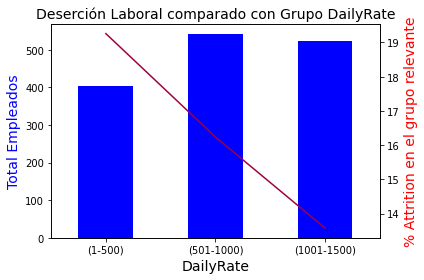

In [339]:
# Deserción Laboral comparada con el grupo de tarifa diaria
graph_df(columna = 'DailyRate', X = df2)

La mayor deserción laboral se presenta en los trabajadores que menos ganan a diario, los que ganan entre 1-500 dólares poseen una deserción del 19.25%. La deserción disminuye entre mayor sea su tarifa diaria.

In [340]:
#Department
table_df(columna = 'Department', X = df2)
table_df(columna = 'Department', X = df2)

,Department,Total Department,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Human Resources,63,12,19.047619,5.063291
1,Research & Development,961,133,13.839750,56.118143
2,Sales,446,92,20.627803,38.818565


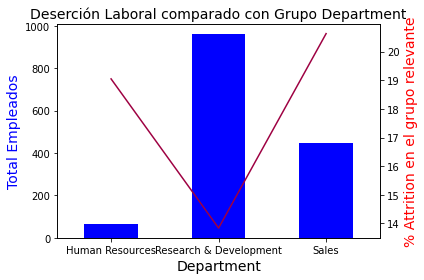

In [341]:
# Deserción Laboral comparada con el grupo de departamentos
graph_df(columna = 'Department', X = df2)

El departamento de Investigación y Desarrollo (Research & Development) es el que posee menor tasa de deserción del 13.84% y el de mayor deserción el depatamento de Ventas (Sales) con el 20.62%.

In [342]:
#DistanceFromHome
table_df(columna = 'DistanceFromHome', X = df2)
bins = [1, 5, 10, 30]
group_names = ['(1-5)', '(6-10)', '(+10)']
df2['DistanceFromHome'] = pd.cut(employee['DistanceFromHome'], bins, labels = group_names)
table_df(columna = 'DistanceFromHome', X = df2)

,DistanceFromHome,Total DistanceFromHome,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,(1-5),424,61,14.386792,25.738397
1,(6-10),394,57,14.467005,24.050633
2,(+10),444,93,20.945946,39.240506


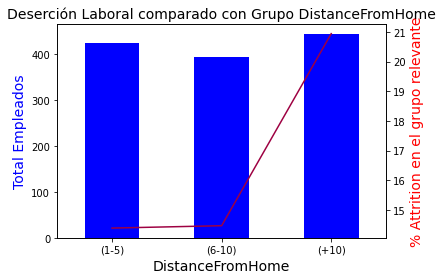

In [343]:
# Deserción Laboral comparada con la distacia desde la casa
graph_df(columna = 'DistanceFromHome', X = df2)

Poseen una deserción laboral más alta del 20.95% las personas que vinen a más de 10 millas del lugar de trabajo. La deserción aumenta con la distancia entre la casa y el trabajo.

In [344]:
#Education
df2['Education'] = df2['Education'].map({1:'Below College', 2:'College', 3:'Bachelor', 4:'Master', 5:'Doctor'})
table_df(columna = 'Education', X = df2)

,Education,Total Education,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Bachelor,572,99,17.307692,41.772152
1,Below College,170,31,18.235294,13.080169
2,College,282,44,15.602837,18.565401
3,Doctor,48,5,10.416667,2.109705
4,Master,398,58,14.572864,24.472574


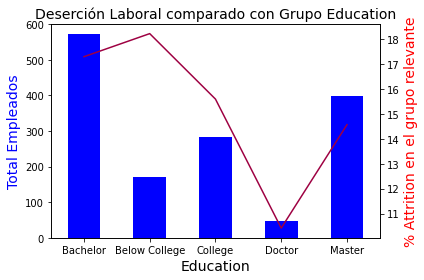

In [345]:
# Deserción Laboral comparada con el grupo de educación
graph_df(columna = 'Education', X = df2)

Los empleados que cursan niveles inferiores de escolaridad son los que tienen mayor Deserción Laboral con el Bachelor del 17.30% y Bellow College con el 18.23% de deserción laboral, entre ambos representan el 35.53% de la deserción de la empresa, siendo muy representativo.

In [346]:
#EducationField
table_df(columna = 'EducationField', X = df2)
table_df(columna = 'EducationField', X = df2)

,EducationField,Total EducationField,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Human Resources,27,7,25.925926,2.953586
1,Life Sciences,606,89,14.686469,37.552743
2,Marketing,159,35,22.012579,14.767932
3,Medical,464,63,13.577586,26.582278
4,Other,82,11,13.414634,4.641350
5,Technical Degree,132,32,24.242424,13.502110


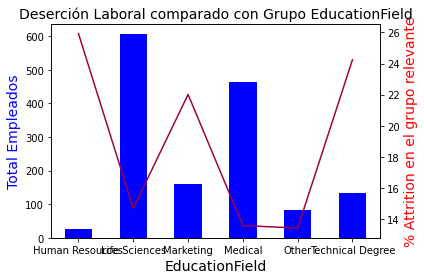

In [347]:
# Deserción Laboral comparada con el grupo de campo educativo
graph_df(columna = 'EducationField', X = df2)

El área de educación que posee mayor deserción laboral es el de Recursos Humanos con el 25.93% seguido de los que poseen títulos técnicos con el 24.24%.

In [348]:
#EmployeeCount
df2['EmployeeCount'].unique()

array([1])

Esta característica no es representativa. Se eliminará más adelante de los datos a analizar.

In [349]:
#EmployeeNumber
table_df(columna = 'EmployeeNumber', X = df2)
bins = [1, 500, 1000, 1500, 2068]
group_names = ['(1-500)', '(501-1000)', '(1001-1500)', '(1501-2068)']
df2['EmployeeNumber'] = pd.cut(employee['EmployeeNumber'], bins, labels = group_names)
table_df(columna = 'EmployeeNumber', X = df2)

,EmployeeNumber,Total EmployeeNumber,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,(1-500),376,56,14.893617,23.628692
1,(501-1000),340,58,17.058824,24.472574
2,(1001-1500),348,66,18.965517,27.848101
3,(1501-2068),405,56,13.827160,23.628692


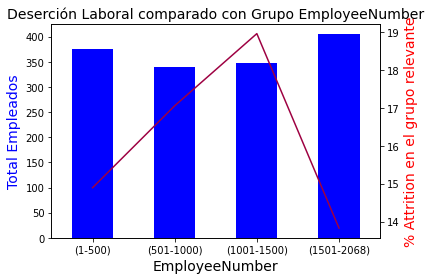

In [350]:
# Deserción Laboral comparada con el grupo de número de empleados de la empresa
graph_df(columna = 'EmployeeNumber', X = df2)

El número de empleados no es determinante en la deserción laboral de la empresa, ya que tiene un comportamiento uniforme en cualquier clasifiación. Se eliminará esta característica del conjunto de datos a analizar más adelante.

In [351]:
#EnvironmentSatisfaction
df2['EnvironmentSatisfaction'] = df2['EnvironmentSatisfaction'].map({1:'Low', 2:'Medium', 3:'High', 4:'Very High'})
table_df(columna = 'EnvironmentSatisfaction', X = df2)

,EnvironmentSatisfaction,Total EnvironmentSatisfaction,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,High,453,62,13.686534,26.160338
1,Low,284,72,25.352113,30.379747
2,Medium,287,43,14.982578,18.143460
3,Very High,446,60,13.452915,25.316456


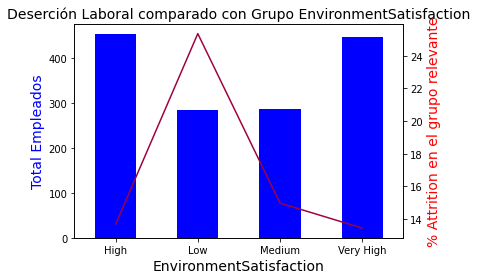

In [352]:
# Deserción Laboral comparada con el grupo satisfación con el ambiente laboral
graph_df(columna = 'EnvironmentSatisfaction', X = df2)

Con una satisfación con el ambiente laboral baja se obtiene el mayor porcentaje de deserción laboral, del 25,35 %

In [353]:
#Gender
table_df(columna = 'Gender', X = df2)
table_df(columna = 'Gender', X = df2)

,Gender,Total Gender,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Female,588,87,14.795918,36.708861
1,Male,882,150,17.006803,63.291139


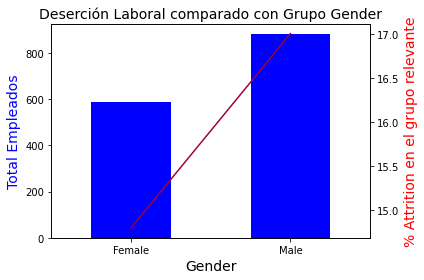

In [354]:
# Deserción Laboral comparada con el género
graph_df(columna = 'Gender', X = df2)

Se tiene una mayor deserción laboral de los hombres respecto a las mujeres con el 17%.

In [355]:
#HourlyRate
table_df(columna = 'EmployeeNumber', X = df2)
bins = [30, 50, 80, 100]
group_names = ['(30-50)', '(51-80)', '(81-100)']
df2['EmployeeNumber'] = pd.cut(employee['EmployeeNumber'], bins, labels = group_names)
table_df(columna = 'EmployeeNumber', X = df2)

,EmployeeNumber,Total EmployeeNumber,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,(30-50),14,5,35.714286,2.109705
1,(51-80),25,4,16.000000,1.687764
2,(81-100),14,1,7.142857,0.421941


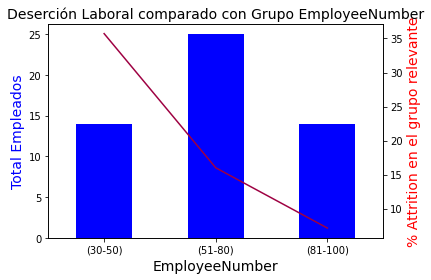

In [356]:
# Deserción Laboral comparada con el grupode número de empleados
graph_df(columna = 'EmployeeNumber', X = df2)

La característica EmployeeNumber no es relevante en el porcetaje de deserción laboral de la compañia. Se eliminará esta característica del conjunto de datos a analizar más adelante.

In [357]:
#JobInvolvement
df2['JobInvolvement'] = df2['JobInvolvement'].map({1:'Low', 2:'Medium', 3:'High', 4:'Very High'})
table_df(columna = 'JobInvolvement', X = df2)

,JobInvolvement,Total JobInvolvement,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,High,868,125,14.400922,52.742616
1,Low,83,28,33.734940,11.814346
2,Medium,375,71,18.933333,29.957806
3,Very High,144,13,9.027778,5.485232


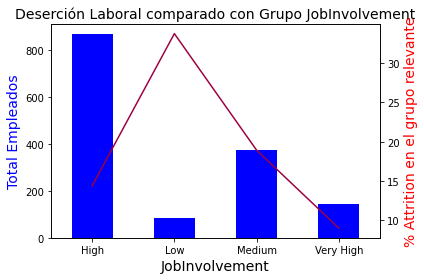

In [358]:
# Deserción Laboral comparada con el grupo de participación en el trabajo
graph_df(columna = 'JobInvolvement', X = df2)

Dentro del grupo de JobInvolvement la característica con mayor relevancia en porcentaje de nivel de deserción laboral fue el nivel bajo con un 33.73%, sin embargo la cantidad de empleados no es representativo. La calificación Hight es la más representativa a nivel compañía con un 14.4% de deserción pero que representa el 52.74% de deserción a nivel empresa.

In [359]:
#JobLevel
df2['JobLevel'] = df2['JobLevel'].map({1:'Level-1', 2:'Level-2', 3:'Level-3', 4:'Level-4', 5:'Level-5'})
table_df(columna = 'JobLevel', X = df2)

,JobLevel,Total JobLevel,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Level-1,543,143,26.335175,60.337553
1,Level-2,534,52,9.737828,21.940928
2,Level-3,218,32,14.678899,13.502110
3,Level-4,106,5,4.716981,2.109705
4,Level-5,69,5,7.246377,2.109705


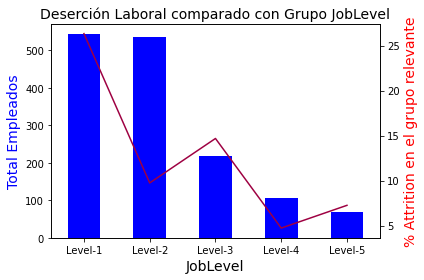

In [360]:
# Deserción Laboral comparada con el grupo de nivel de trabajo
graph_df(columna = 'JobLevel', X = df2)

La deserción disminuye con el aumento del nivel de trabajo. Se tiene el mayor porcetaje de deserción en el Nivel-1 con 26.33%.

In [361]:
#JobRole
table_df(columna = 'JobRole', X = df2)
table_df(columna = 'JobRole', X = df2)

,JobRole,Total JobRole,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Healthcare Representative,131,9,6.870229,3.797468
1,Human Resources,52,12,23.076923,5.063291
2,Laboratory Technician,259,62,23.938224,26.160338
3,Manager,102,5,4.901961,2.109705
4,Manufacturing Director,145,10,6.896552,4.219409
5,Research Director,80,2,2.500000,0.843882
6,Research Scientist,292,47,16.095890,19.831224
7,Sales Executive,326,57,17.484663,24.050633
8,Sales Representative,83,33,39.759036,13.924051


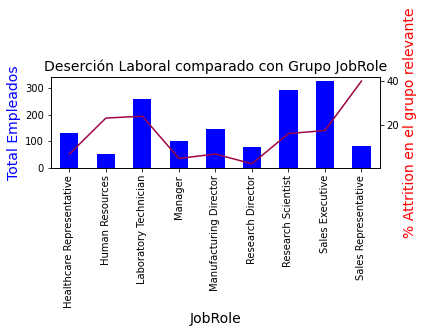

In [362]:
# Deserción Laboral comparada con el grupo de nivel de trabajo
graph_df(columna = 'JobRole', X = df2, z = 90)

Los Técnicos de Laboratorio poseen el mayor nivel de deserción a nivel de la compañia con el 26.16% seguido del Ejecutivo de Ventas con un 24.05%.

In [363]:
#JobSatisfaction
df2['JobSatisfaction'] = df2['JobSatisfaction'].map({1:'Low', 2:'Medium', 3:'High', 4:'Very High'}) 
table_df(columna = 'JobSatisfaction', X = df2)

,JobSatisfaction,Total JobSatisfaction,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,High,442,73,16.515837,30.801688
1,Low,289,66,22.837370,27.848101
2,Medium,280,46,16.428571,19.409283
3,Very High,459,52,11.328976,21.940928


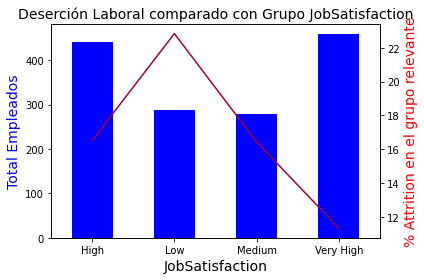

In [364]:
# Deserción Laboral comparada con el grupo de satisfacción laboral
graph_df(columna = 'JobSatisfaction', X = df2)

Es sorpresivo que el mayor porcentaje de Deserción Laboral se presente con un nivel alto (High) de satisfacción laboral con un 30.80% a nivel de toda la compañía. 

In [365]:
#MaritalStatus
table_df(columna = 'MaritalStatus', X = df2)
table_df(columna = 'MaritalStatus', X = df2)

,MaritalStatus,Total MaritalStatus,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Divorced,327,33,10.091743,13.924051
1,Married,673,84,12.481426,35.443038
2,Single,470,120,25.531915,50.632911


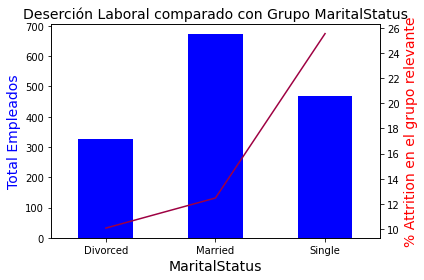

In [366]:
# Deserción Laboral comparada con el grupo de estado civil
graph_df(columna = 'MaritalStatus', X = df2)

Los empleados Solteros son los que tienen mayor porcentaje de deserción laboral a nivel de la empresa con un 50.63%.

In [367]:
#MonthlyIncome
table_df(columna = "MonthlyIncome", X = df2)
bins = [1000, 2000, 3000, 5000, 7500, 10000, 15000, 20000]
group_names = ['1000-2500', '2501-3000', '3501-5000', '5001-7500', '7501-10000', '10001-15000', '15001-20000']             
df2['MonthlyIncome'] = pd.cut(employee['MonthlyIncome'], bins, labels = group_names)
table_df(columna = 'MonthlyIncome', X = df2)

,MonthlyIncome,Total MonthlyIncome,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,1000-2500,33,18,54.545455,7.594937
1,2501-3000,362,95,26.243094,40.084388
2,3501-5000,354,50,14.124294,21.097046
3,5001-7500,310,30,9.677419,12.658228
4,7501-10000,130,19,14.615385,8.016878
5,10001-15000,148,20,13.513514,8.438819
6,15001-20000,133,5,3.759398,2.109705


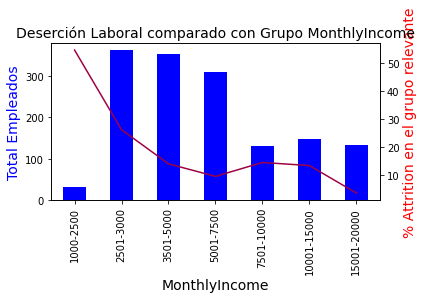

In [368]:
# Deserción Laboral comparada con el grupo de sueldo mensual
graph_df(columna = 'MonthlyIncome', X = df2, z = 90)

La mayor deserción laboral se da en los rangos salariales de 2501-3000 dólares con un 40% a nivel de toda la empresa.

In [369]:
#MonthlyRate
table_df(columna = "MonthlyRate", X = df2)
bins = [2000, 5000, 10000, 15000, 20000, 27000]
group_names = ['2000-5000', '5001-10000', '10001-15000', '15001-20000', '20001-27000']             
df2['MonthlyRate'] = pd.cut(employee['MonthlyRate'], bins, labels = group_names)
table_df(columna = 'MonthlyRate', X = df2)

,MonthlyRate,Total MonthlyRate,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,2000-5000,171,30,17.543860,12.658228
1,5001-10000,316,42,13.291139,17.721519
2,10001-15000,287,53,18.466899,22.362869
3,15001-20000,298,44,14.765101,18.565401
4,20001-27000,398,68,17.085427,28.691983


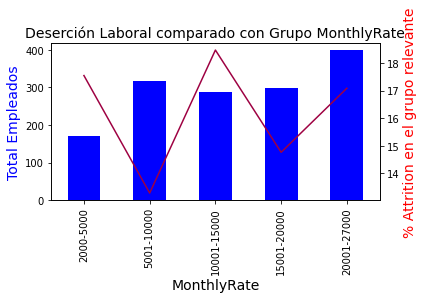

In [370]:
# Deserción Laboral comparada con el grupo de la tasa mensual
graph_df(columna = 'MonthlyRate', X = df2, z = 90)

Se observa que el grupo con mayor deserción laboral es el de 20001-27000 con un 28.29% a nivel de la empresa.

In [371]:
#NumCompaniesWorked
table_df(columna = 'NumCompaniesWorked', X = df2)
table_df(columna = 'NumCompaniesWorked', X = df2)

,NumCompaniesWorked,Total NumCompaniesWorked,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,0,197,23,11.675127,9.704641
1,1,521,98,18.809981,41.350211
2,2,146,16,10.958904,6.751055
3,3,159,16,10.062893,6.751055
4,4,139,17,12.230216,7.172996
5,5,63,16,25.396825,6.751055
6,6,70,16,22.857143,6.751055
7,7,74,17,22.972973,7.172996
8,8,49,6,12.244898,2.531646
9,9,52,12,23.076923,5.063291


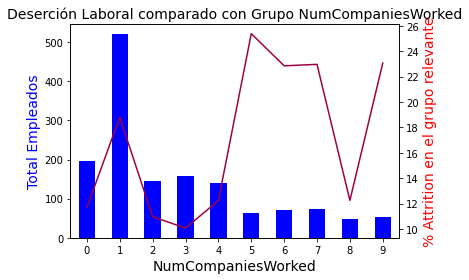

In [372]:
# Deserción Laboral comparada con la cantidad de compañía en que ha trabajado
graph_df(columna = 'NumCompaniesWorked', X = df2)

A nivel de la empresa, quienes tienen una sola experiencia anterior son los que tienen mayor nivel de deserción laboral con un 41.35% a nivel de la empresa.

In [373]:
#Over18
df2['Over18'].unique()

array(['Y'], dtype=object)

Esta característica no es relevante. Se eliminará esta característica del conjunto de datos a analizar más adelante.

In [374]:
#OverTime
table_df(columna = 'OverTime', X = df2)
table_df(columna = 'OverTime', X = df2)

,OverTime,Total OverTime,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,No,1054,110,10.436433,46.413502
1,Yes,416,127,30.528846,53.586498


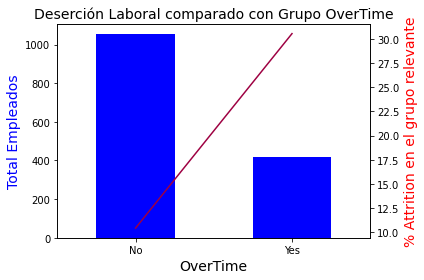

In [375]:
# Deserción Laboral comparada con trabajo extra
graph_df(columna = 'OverTime', X = df2)

Esta característica es muy representativa indicando que OverTime o tiempo extra de trabajo del horario laboral tiene un porcentaje alto de deserción laboral con el 53.58% a nivel de la empresa.

In [376]:
#PercentSalaryHike
table_df(columna = "PercentSalaryHike", X = df2)
bins = [10, 12, 15, 18, 20, 25]
group_names = ['10-12', '13-15', '16-18', '18-20', '21-25']          
df2['PercentSalaryHike'] = pd.cut(employee['PercentSalaryHike'], bins, labels = group_names)
table_df(columna = 'PercentSalaryHike', X = df2)

,PercentSalaryHike,Total PercentSalaryHike,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,10-12,408,74,18.137255,31.223629
1,13-15,511,76,14.872798,32.067511
2,16-18,249,41,16.465863,17.299578
3,18-20,131,16,12.213740,6.751055
4,21-25,171,30,17.543860,12.658228


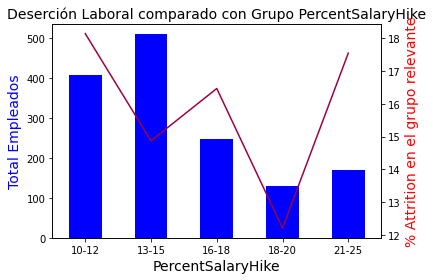

In [377]:
# Deserción Laboral comparada con el grupo de porcentaje de aumento salarial
graph_df(columna = 'PercentSalaryHike', X = df2)

La mayor deserción laboral se da en los aumentos salariales más bajos, 32% a nivel de la compañía para los aumentos entre 13-15 dólares y del 31.22% a nivel de la compañia a los aumentos entre 10-12 dólares.

In [378]:
#PerformanceRating
df2['PerformanceRating'] = df2['PerformanceRating'].map({1:'Low', 2:'Good', 3:'Excellent', 4:'Outstanding'}) 
table_df(columna = 'PerformanceRating', X = df2)

,PerformanceRating,Total PerformanceRating,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Excellent,1244,200,16.077170,84.388186
1,Outstanding,226,37,16.371681,15.611814


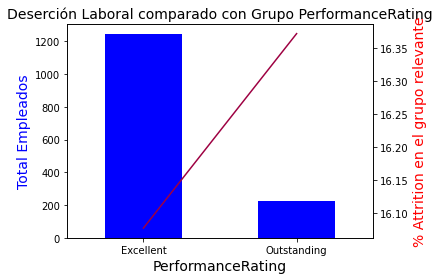

In [379]:
# Deserción Laboral comparada con el grupo rendimiento
graph_df(columna = 'PerformanceRating', X = df2)

A nivel de la compañía las persona con un rendimiento Excelente son las que tienen mayor tasa de deserción laboral con un 84.38% a nivel de la empresa, lo cual por lacantidad de empleados en esa clasificación es muy representativa.

In [380]:
#RelationshipSatisfaction
df2['RelationshipSatisfaction'] = df2['RelationshipSatisfaction'].map({1:'Low', 2:'Medium', 3:'High', 4:'Very High'})
table_df(columna = 'RelationshipSatisfaction', X = df2)

,RelationshipSatisfaction,Total RelationshipSatisfaction,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,High,459,71,15.468410,29.957806
1,Low,276,57,20.652174,24.050633
2,Medium,303,45,14.851485,18.987342
3,Very High,432,64,14.814815,27.004219


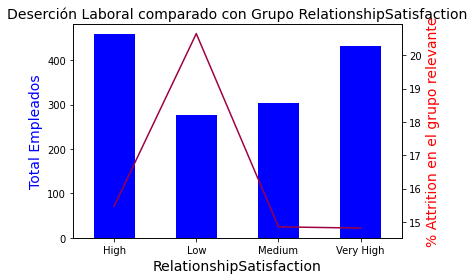

In [381]:
# Deserción Laboral comparada con el grupo rendimiento
graph_df(columna = 'RelationshipSatisfaction', X = df2)

Es sorpresivo que a nivel de la empresa los empleados que indicaron un nivel de satisfacción Alto (High) sean los que tiene la mayor tasa de deserción laboral del 29.95% a nievl de la empresa.

In [382]:
#StandardHours
df2['StandardHours'].unique()

array([80])

Esta característica no es relevante. Se eliminará esta característica del conjunto de datos a analizar más adelante.

In [383]:
#StockOptionLevel
table_df(columna = 'StockOptionLevel', X = df2)
table_df(columna = 'StockOptionLevel', X = df2)

,StockOptionLevel,Total StockOptionLevel,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,0,631,154,24.405705,64.978903
1,1,596,56,9.395973,23.628692
2,2,158,12,7.594937,5.063291
3,3,85,15,17.647059,6.329114


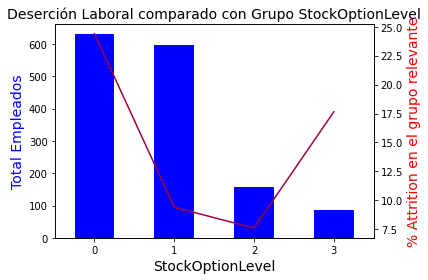

In [384]:
# Deserción Laboral comparada con la cantidad de acciones
graph_df(columna = 'StockOptionLevel', X = df2)

Los trabajadores sin acciones son los que teiene mayor nivel de deserción laboral con el 64.97% a nivel de la empresa.

In [385]:
#TotalWorkingYears
table_df(columna = "TotalWorkingYears", X = df2)
bins = [0, 1, 5, 10, 15, 20, 40]
group_names = ['0-1', '2-5', '6-10', '11-15', '16-20', '20+']         
df2['TotalWorkingYears'] = pd.cut(employee['TotalWorkingYears'], bins, labels = group_names)
table_df(columna = 'TotalWorkingYears', X = df2)

,TotalWorkingYears,Total TotalWorkingYears,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,0-1,81,40,49.382716,16.877637
1,2-5,224,46,20.535714,19.409283
2,6-10,607,91,14.991763,38.396624
3,11-15,191,24,12.565445,10.126582
4,16-20,149,15,10.067114,6.329114
5,20+,207,16,7.729469,6.751055


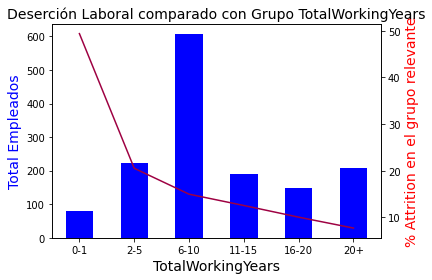

In [386]:
# Deserción Laboral comparada con la cantidad de años de trabajar en la misma empresa
graph_df(columna = 'TotalWorkingYears', X = df2)

Se observa una dismunución de la deserción laboral a medida que se tiene mayor tiempo de trabajo en la misma empresa. Sin embargo a nivel de la empresa, se tiene la mayor deserción con una experiencie de 6-10 años con un 38.39%.

In [387]:
#TrainingTimesLastYear
table_df(columna = 'TrainingTimesLastYear', X = df2)
table_df(columna = 'TrainingTimesLastYear', X = df2)

,TrainingTimesLastYear,Total TrainingTimesLastYear,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,0,54,15,27.777778,6.329114
1,1,71,9,12.676056,3.797468
2,2,547,98,17.915905,41.350211
3,3,491,69,14.052953,29.113924
4,4,123,26,21.138211,10.970464
5,5,119,14,11.764706,5.907173
6,6,65,6,9.230769,2.531646


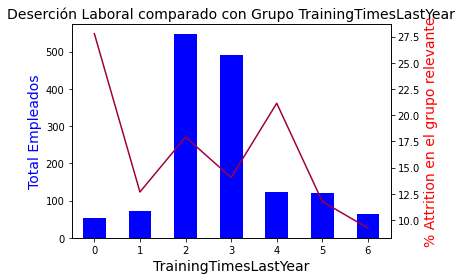

In [388]:
# Deserción Laboral comparada con la cantidad de entrenamientos en el año anterior
graph_df(columna = 'TrainingTimesLastYear', X = df2)

Los empleados que tuvieron 2 y 3 entrenamientos el año anterior tienen el mayor número de deserciones las cuales componen el 70.5% de todas las deserciones en la empresa.

In [389]:
#WorkLifeBalance
df2['WorkLifeBalance'] = df2['WorkLifeBalance'].map({1:'Bad', 2:'Good', 3:'Better', 4:'Best'})
table_df(columna = 'WorkLifeBalance', X = df2)

,WorkLifeBalance,Total WorkLifeBalance,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,Bad,80,25,31.250000,10.548523
1,Best,153,27,17.647059,11.392405
2,Better,893,127,14.221725,53.586498
3,Good,344,58,16.860465,24.472574


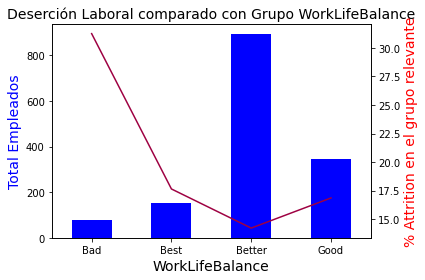

In [390]:
# Deserción Laboral comparada con el nivel de balance entre la vida y el trabajo
graph_df(columna = 'WorkLifeBalance', X = df2)

A nivel de la clasificación se tiene la mayor deserción con un nivel malo de equilibrio con un 31.25%, sin embargo a nivel de la empresa se tiene mayor deserción las personas que indicaron tener un equilibrio mejor (Better) con un 53.58%.

In [391]:
#YearsAtCompany
table_df(columna = "YearsAtCompany", X = df2)
bins = [0, 1, 5, 10, 40]
group_names = ['1', '2-5', '6-10', '10+']          
df2['YearsAtCompany'] = pd.cut(employee['YearsAtCompany'], bins, labels = group_names)
table_df(columna = 'YearsAtCompany', X = df2)

,YearsAtCompany,Total YearsAtCompany,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,1,171,59,34.502924,24.894515
1,2-5,561,87,15.508021,36.708861
2,6-10,448,55,12.276786,23.206751
3,10+,246,20,8.130081,8.438819


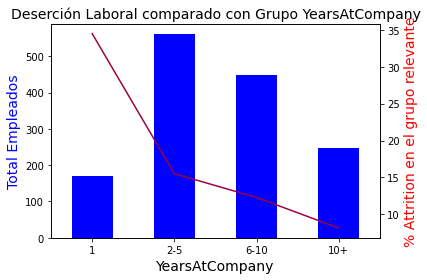

In [392]:
# Deserción Laboral comparada con el nivel de balance entre la vida y el trabajo
graph_df(columna = 'YearsAtCompany', X = df2)

La mayor deserción laboral se encuetra en los empleados del 2-5 años con un 36.70% a nivel de ltoda la compañia. En el grupo de clasificación la mayor deserción es con 1 año de experiencia con el 34.5%.

In [393]:
#YearsInCurrentRole
table_df(columna = "YearsInCurrentRole", X = df2)
bins = [0, 1, 4, 6, 7, 10, 18]
group_names = ['1', '2-4', '5-6', '7', '8-10', '10+']         
df2['YearsInCurrentRole'] = pd.cut(employee['YearsInCurrentRole'], bins, labels = group_names)
table_df(columna = 'YearsInCurrentRole', X = df2)

,YearsInCurrentRole,Total YearsInCurrentRole,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,1,57,11,19.298246,4.641350
1,2-4,611,99,16.202946,41.772152
2,5-6,73,3,4.109589,1.265823
3,7,222,31,13.963964,13.080169
4,8-10,185,15,8.108108,6.329114
5,10+,78,5,6.410256,2.109705


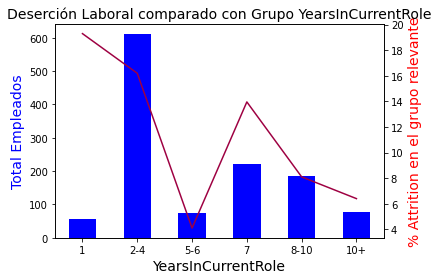

In [394]:
# Deserción Laboral comparada con los años de trabajo en el mismo puesto
graph_df(columna = 'YearsInCurrentRole', X = df2)

La mayor desrción laboral ocurre en persona que han durado en el mismo cargo entre 2-4 años con un 41.77% a nivel de la empresa.

In [395]:
#YearsSinceLastPromotion
table_df(columna = "YearsSinceLastPromotion", X = df2)
bins = [0, 1, 2, 3, 4, 7, 8, 16]
group_names = ['0', '1', '2', '3', '4-6', '7', '8+']      
df2['YearsSinceLastPromotion'] = pd.cut(employee['YearsSinceLastPromotion'], bins, labels = group_names)
table_df(columna = 'YearsSinceLastPromotion', X = df2)

,YearsSinceLastPromotion,Total YearsSinceLastPromotion,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,0,357,49,13.725490,20.675105
1,1,159,27,16.981132,11.392405
2,2,52,9,17.307692,3.797468
3,3,61,5,8.196721,2.109705
4,4-6,153,24,15.686275,10.126582
5,7,18,0,0.000000,0.000000
6,8+,89,13,14.606742,5.485232


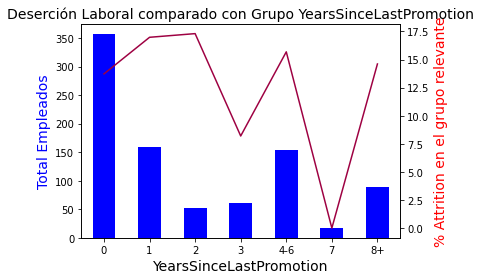

In [396]:
# Deserción Laboral comparada con los años de trabajo en el mismo puesto
graph_df(columna = 'YearsSinceLastPromotion', X = df2)

Las personas recien egresadas con las que tienen mayor porcentaje de deserción laboral con el 20.67%. a nivel de la compañía.

In [397]:
#YearsWithCurrManager
table_df(columna = "YearsWithCurrManager", X = df2)
bins = [0, 1, 2, 3, 4, 7, 8, 16]
group_names = ['0', '1', '2', '3', '4-6', '7', '8+']      
df2['YearsWithCurrManager'] = pd.cut(employee['YearsWithCurrManager'], bins, labels = group_names)
table_df(columna = 'YearsWithCurrManager', X = df2)

,YearsWithCurrManager,Total YearsWithCurrManager,# Deserción Laboral(Attrition),% de Deserción Laboral(Attrition) en el grupo relevante,% de Deserción Laboral en la Compañia
0,0,76,11,14.473684,4.641350
1,1,344,50,14.534884,21.097046
2,2,142,19,13.380282,8.016878
3,3,98,11,11.224490,4.641350
4,4-6,276,39,14.130435,16.455696
5,7,107,10,9.345794,4.219409
6,8+,157,12,7.643312,5.063291


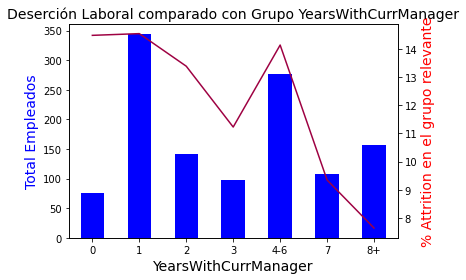

In [398]:
# Deserción Laboral comparada con los años con el mismo jefe
graph_df(columna = 'YearsWithCurrManager', X = df2)

La mayor deserción laboral de produjo cuando trabajaban con el mismo jefe durante 1 año con el 21.09% a nivel de la empresa.

In [399]:
employee = employee.drop(columns=['DailyRate'])
df2 = df2.drop(columns=['DailyRate'])

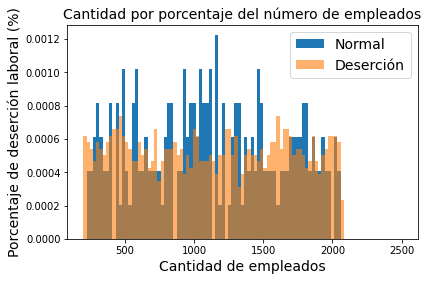

In [400]:
#EmployeeNumber
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["EmployeeNumber"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["EmployeeNumber"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del número de empleados")
plt.xlabel("Cantidad de empleados")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("employeenumber_attrion")  # extra code
plt.show()

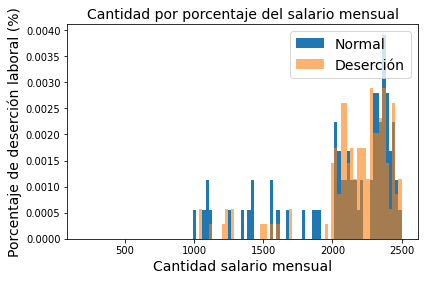

In [401]:
#MonthlyIncome
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["MonthlyIncome"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["MonthlyIncome"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del salario mensual")
plt.xlabel("Cantidad salario mensual")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("monthlyincome_attrion")  # extra code
plt.show()

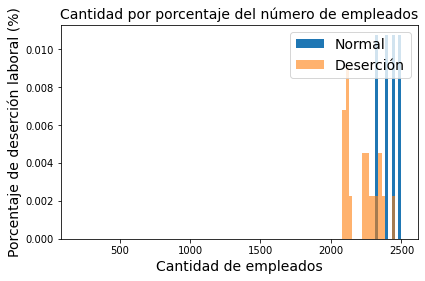

In [402]:
#MonthlyRate
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["MonthlyRate"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["MonthlyRate"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del número de empleados")
plt.xlabel("Cantidad de empleados")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("monthlyrate_attrion")  # extra code
plt.show()

Se realiza la visualización de la proporción de datos para cada variable categórica

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

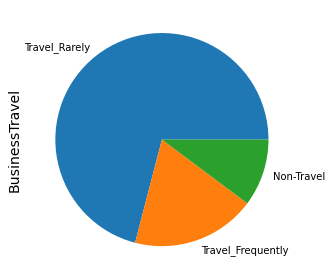

In [403]:
employee["BusinessTravel"].value_counts().plot(kind='pie')
save_fig("BusinessTravel_count")  # extra code
employee["BusinessTravel"].value_counts()

* "BusinessTravel" se clasifica como una variable Categórica - Nominal

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

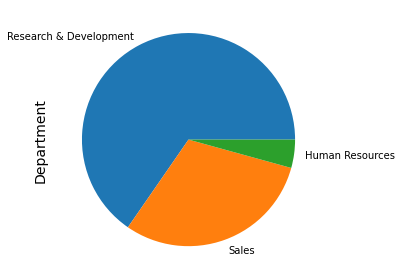

In [404]:
employee["Department"].value_counts().plot(kind='pie')
save_fig("Department_count")  # extra code
employee["Department"].value_counts()

* "Department" se clasifica como una variable Categórica - Nominal

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

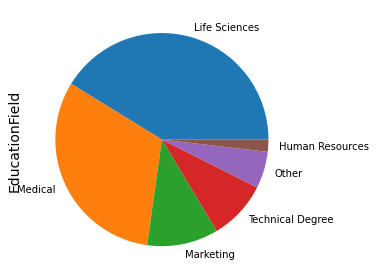

In [405]:
employee["EducationField"].value_counts().plot(kind='pie')
save_fig("EducationField_count")  # extra code
employee["EducationField"].value_counts()

* "EducationField" se clasifica como una variable Categórica - Nominal

Male      882
Female    588
Name: Gender, dtype: int64

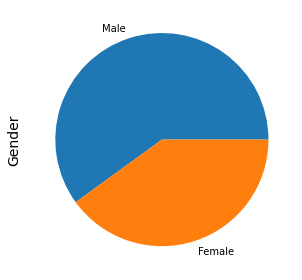

In [406]:
employee["Gender"].value_counts().plot(kind='pie')
save_fig("Gender_count")  # extra code
employee["Gender"].value_counts()

* "Gender" se clasifica como una variable Categórica - Nominal

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

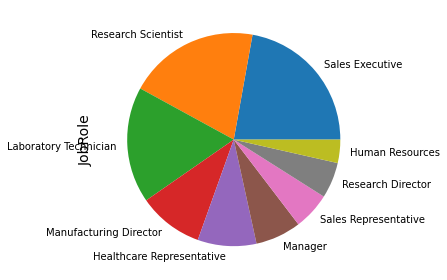

In [407]:
employee["JobRole"].value_counts().plot(kind='pie')
save_fig("JobRole_count")  # extra code
employee["JobRole"].value_counts()

"JobRole" se clasifica como una variable Categórica - Nominal

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

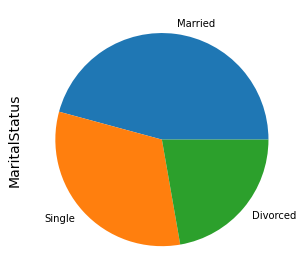

In [408]:
employee["MaritalStatus"].value_counts().plot(kind='pie')
save_fig("MaritalStatus_count")  # extra code
employee["MaritalStatus"].value_counts()

* "MaritalStatus" se clasifica como una variable Categórica - Nominal

No     1054
Yes     416
Name: OverTime, dtype: int64

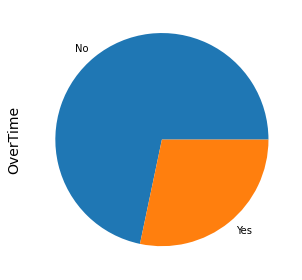

In [409]:
employee["OverTime"].value_counts().plot(kind='pie')
save_fig("OverTime_count")  # extra code
employee["OverTime"].value_counts()

* "OverTime" se clasifica como una variable Categórica - Binaria



In [410]:
employee["Over18"].value_counts()

Y    1470
Name: Over18, dtype: int64

* "Over18" se clasifica como una variable Categórica - Binaria.<br>

* De acuerdo con la clasificación, la variable "**Over18**" no es relevante ya que no presenta variación en alguna de las instacias del conjunto de datos.

Resumen de los atributos numéricos:

In [411]:
employee.describe()

,Age,Attrition,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,0.367863,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,0.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [412]:
employee.nunique().sort_values()

Over18                         1
StandardHours                  1
EmployeeCount                  1
PerformanceRating              2
Attrition                      2
OverTime                       2
Gender                         2
MaritalStatus                  3
Department                     3
BusinessTravel                 3
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
WorkLifeBalance                4
RelationshipSatisfaction       4
StockOptionLevel               4
Education                      5
JobLevel                       5
EducationField                 6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate

In [413]:
employee = employee.drop(columns=['Over18'])
employee = employee.drop(columns=['StandardHours'])
employee = employee.drop(columns=['EmployeeCount'])
employee = employee.drop(columns=['EmployeeNumber'])

In [414]:
duplicate = employee[employee.duplicated()]
duplicate

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


Entender la distribución de los datos:

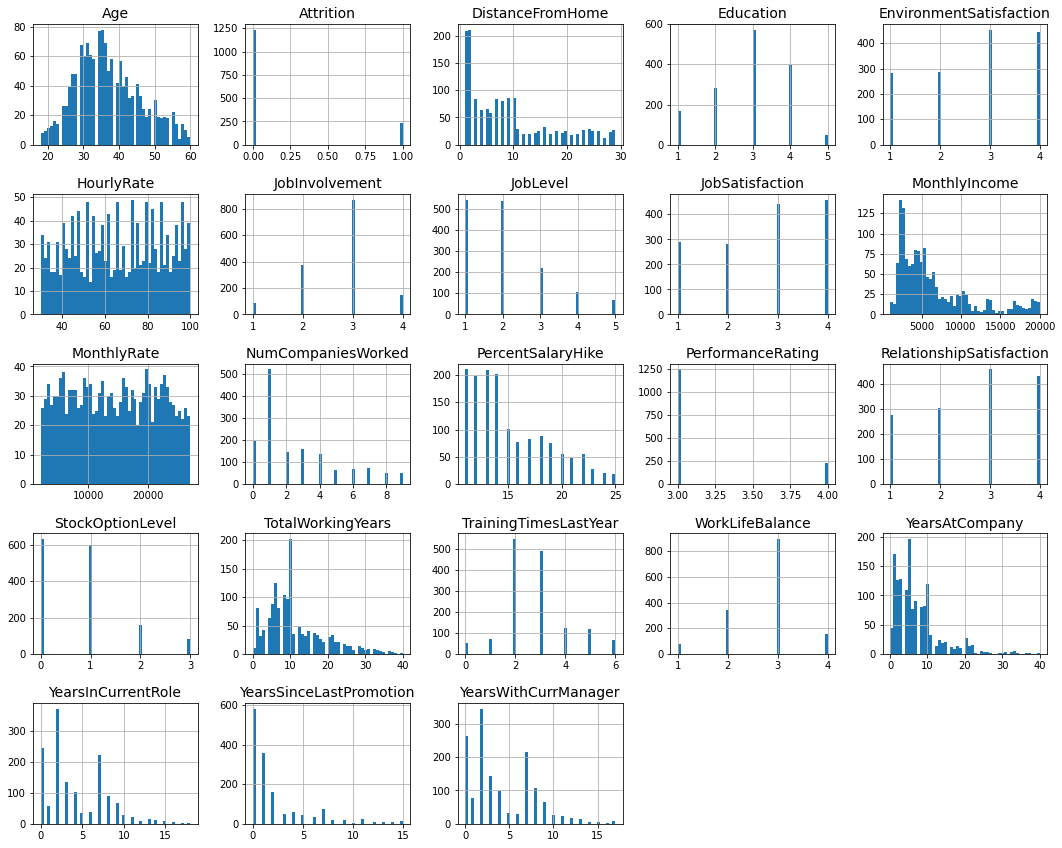

In [415]:
import matplotlib.pyplot as plt

# código extra - las siguientes 5 líneas definen los tamaños de fuente por defecto
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

employee.hist(bins=50, figsize=(15, 12))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

In [416]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EnvironmentSatisfaction   1470 non-null   int64 
 8   Gender                    1470 non-null   object
 9   HourlyRate                1470 non-null   int64 
 10  JobInvolvement            1470 non-null   int64 
 11  JobLevel                  1470 non-null   int64 
 12  JobRole                   1470 non-null   object
 13  JobSatisfaction           1470 non-null   int64 
 14  MaritalStatus           

In [417]:
#Mover la variable objetivo al final
front = employee['Attrition']
employee.drop(labels=['Attrition'], axis=1,inplace=True)
employee.insert(employee.columns.shape[0],'Attrition',front)
employee.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,41,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,94,3,...,1,0,8,0,1,6,4,0,5,1
1,49,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,61,2,...,4,1,10,3,3,10,7,1,7,0
2,37,Travel_Rarely,Research & Development,2,2,Other,4,Male,92,2,...,2,0,7,3,3,0,0,0,0,1
3,33,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,56,3,...,3,0,8,3,3,8,7,3,0,0
4,27,Travel_Rarely,Research & Development,2,1,Medical,1,Male,40,3,...,4,1,6,3,3,2,2,2,2,0


In [418]:
#Transformación de las variables
for column in employee.columns:
  if employee[column].dtype == np.number:
    continue
  employee[column] = LabelEncoder().fit_transform(employee[column])

In [419]:
X = employee.drop(columns=['Attrition'])
y = employee['Attrition']

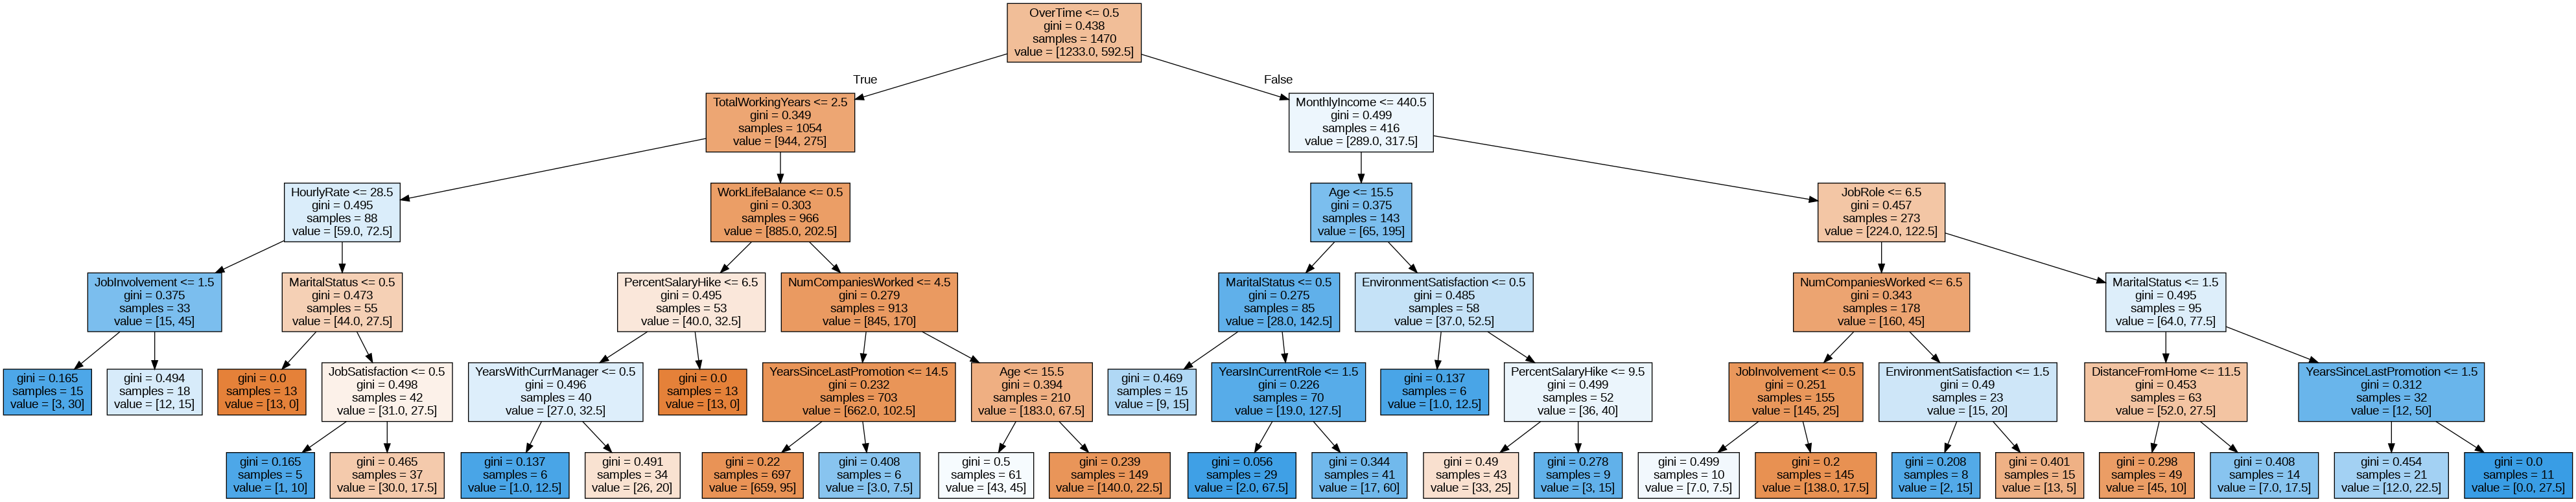

In [420]:
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from subprocess import check_call
from IPython.display import Image as PImage
%matplotlib inline 

# Crear Arbol de decision con profundidad = 5  
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 5,
                                            class_weight={1:2.5})

decision_tree.fit(X, y)
                  
# exportar el modelo a archivo .dot
with open(r"/content/images/end_to_end_project/arbol_decision.dot", 'w') as f:
  f = open("/content/images/end_to_end_project/arbol_decision.dot", 'w')
  tree.export_graphviz(decision_tree, out_file = f, feature_names = X.columns, filled=True)
  f.close()
  
 # Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'/content/images/end_to_end_project/arbol_decision.dot','-o',r'/content/images/end_to_end_project/arbol_decision.png'])
PImage("/content/images/end_to_end_project/arbol_decision.png")

In [421]:
# Nombres de las características
decision_tree.feature_names_in_

array(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'], dtype=object)

Esta es una visión general de la correlación que existe entre las variables a evaluar y la variable objetivo. Partiendo por el valor mínimo de entropía en los nodos se puede determinar que la rama con variables "OverTime", "TotalWorkingYears", "WorkLifeBalance" poseen la mejor alternativa a evaluar para enncontrar los factores de mayor peso en la deserción laboral.

## Crear un conjunto de pruebas (Test Set)

Se crea el conjunto de datos de entrenamiento del 80% de los datos y el conjunto de datos de pruebas con el 20% estratificado por la variable de objetivo para conservar el comportamiento de cada conjunto de datos respecto al conjunto de datos original:

In [422]:
from sklearn.model_selection import train_test_split #Divisor de los datos de entrenamiento 

strat_train_set, strat_test_set = train_test_split(employee, test_size=0.2, stratify=employee["Attrition"], random_state=20) #random_state -> semilla

Se categorizan las variables de tipo numérico:

In [423]:
numerical_columns = strat_train_set.drop(columns=['Attrition']).select_dtypes(include=np.number).columns
numerical_columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

Se categorizan las variables categóricas

In [424]:
categorical_columns = strat_train_set.drop(columns=['Attrition']).select_dtypes(exclude=np.number).columns
categorical_columns

Index([], dtype='object')

Se construye pipeline para los datos numéricos:

In [425]:
numeric_transformer = Pipeline(
    steps=[("numerical_imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler())])

Se construye pipeline para los datos categóricos:

In [426]:
categorical_transformer = Pipeline(
    steps=[("label_encoder",  LabelEncoder())])

Se combina pipelines

In [427]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numeric_transformer, numerical_columns),
        ("categorical", categorical_transformer, categorical_columns),
    ]
)

In [428]:
strat_train_set

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
546,11,2,2,9,2,1,2,1,69,2,...,2,0,1,6,2,1,0,0,0,0
837,22,1,1,8,3,3,1,0,58,2,...,2,0,20,3,1,18,7,2,13,0
1244,12,1,1,1,3,5,3,0,48,1,...,3,0,10,2,2,9,7,0,7,0
604,24,2,1,28,2,1,1,1,68,2,...,3,1,10,3,1,9,8,7,8,0
944,10,0,1,0,2,1,2,0,25,0,...,0,3,10,6,2,9,8,7,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,3,2,2,11,2,1,2,0,60,3,...,3,0,1,0,2,1,0,0,0,1
919,41,2,1,17,3,3,3,1,37,2,...,3,0,25,6,1,9,7,5,4,0
1362,27,1,1,0,3,3,1,1,14,2,...,2,0,12,3,2,4,2,0,3,0
171,1,1,2,0,0,5,2,0,70,0,...,0,0,1,5,3,0,0,0,0,1


In [429]:
processed_train = preprocessor.fit_transform(strat_train_set)
pd.DataFrame(processed_train).head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-0.866280,0.580062,1.397375,0.083196,0.094489,-0.938161,0.261854,0.821714,1.616819,0.396857,...,-0.419524,0.252007,-0.925806,-1.322485,2.501991,0.336336,-0.995488,-1.174508,-0.664657,-1.162827
1,0.312823,-0.932472,-0.493664,-0.040026,1.077847,0.573178,-0.651915,-1.216969,1.078698,0.396857,...,-0.419524,0.252007,-0.925806,1.110782,0.165563,-1.076276,1.810348,0.766578,-0.052089,2.479315
2,-0.759089,-0.932472,-0.493664,-0.902579,1.077847,2.084516,1.175623,-1.216969,0.589496,-1.004655,...,-0.419524,1.183957,-0.925806,-0.169884,-0.613246,0.336336,0.324906,0.766578,-0.664657,0.798327
3,0.527206,0.580062,-0.493664,2.424410,0.094489,-0.938161,-0.651915,0.821714,1.567899,0.396857,...,-0.419524,1.183957,0.277230,-0.169884,0.165563,-1.076276,0.324906,1.043876,1.479331,1.078491
4,-0.973472,-2.445006,-0.493664,-1.025801,0.094489,-0.938161,0.261854,-1.216969,-0.535667,-2.406166,...,-0.419524,-1.611893,2.683302,-0.169884,2.501991,0.336336,0.324906,1.043876,1.479331,0.237997


In [430]:
X_train = pd.DataFrame(processed_train)
y_train = strat_train_set['Attrition']

## Descubrir y visualizar los datos para obtener información (insights)

Calcular el coeficiente de correlación estándar:

In [431]:
#Transformación de las variables
for column in employee.columns:
  if employee[column].dtype == np.number:
    continue
  employee[column] = LabelEncoder().fit_transform(employee[column])

In [432]:
corr_matrix = employee.corr()
corr_matrix

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
Age,1.000000,0.024751,-0.031882,-0.001686,0.208034,-0.040873,0.010146,-0.036311,0.024287,0.029820,...,0.053535,0.037510,0.680409,-0.019621,-0.021490,0.309796,0.212901,0.216513,0.202089,-0.159205
BusinessTravel,0.024751,1.000000,-0.009044,-0.024469,0.000757,0.023724,0.004174,-0.032981,0.026528,0.039062,...,-0.035986,-0.016727,0.034144,0.015240,-0.011256,-0.014720,-0.011497,-0.032591,-0.022636,0.000074
Department,-0.031882,-0.009044,1.000000,0.017225,0.007996,0.013720,-0.019395,-0.041583,-0.004144,-0.024586,...,-0.022414,-0.012193,-0.015685,0.036875,0.026383,0.023308,0.056315,0.040061,0.034282,0.063991
DistanceFromHome,-0.001686,-0.024469,0.017225,1.000000,0.021042,0.002013,-0.016075,-0.001851,0.031131,0.008783,...,0.006557,0.044872,0.004560,-0.036942,-0.026556,0.009038,0.018845,0.010029,0.014406,0.077924
Education,0.208034,0.000757,0.007996,0.021042,1.000000,-0.039592,-0.027128,-0.016547,0.016775,0.042438,...,-0.009118,0.018422,0.148188,-0.025100,0.009819,0.067737,0.060236,0.054254,0.069065,-0.031373
EducationField,-0.040873,0.023724,0.013720,0.002013,-0.039592,1.000000,0.043163,-0.002504,-0.021941,-0.002655,...,-0.004378,-0.016185,-0.027833,0.049195,0.041191,-0.018987,-0.010506,0.002326,-0.004130,0.026846
EnvironmentSatisfaction,0.010146,0.004174,-0.019395,-0.016075,-0.027128,0.043163,1.000000,0.000508,-0.049857,-0.008278,...,0.007665,0.003432,-0.002900,-0.019359,0.027627,0.000657,0.018007,0.016194,-0.004999,-0.103369
Gender,-0.036311,-0.032981,-0.041583,-0.001851,-0.016547,-0.002504,0.000508,1.000000,-0.000478,0.017960,...,0.022868,0.012716,-0.046875,-0.038787,-0.002753,-0.030797,-0.041483,-0.026985,-0.030599,0.029453
HourlyRate,0.024287,0.026528,-0.004144,0.031131,0.016775,-0.021941,-0.049857,-0.000478,1.000000,0.042861,...,0.001330,0.050263,-0.002306,-0.008548,-0.004607,-0.020122,-0.024106,-0.026716,-0.020123,-0.006846
JobInvolvement,0.029820,0.039062,-0.024586,0.008783,0.042438,-0.002655,-0.008278,0.017960,0.042861,1.000000,...,0.034297,0.021523,-0.005603,-0.015338,-0.014617,-0.020785,0.008717,-0.024184,0.025976,-0.130016


<AxesSubplot:>

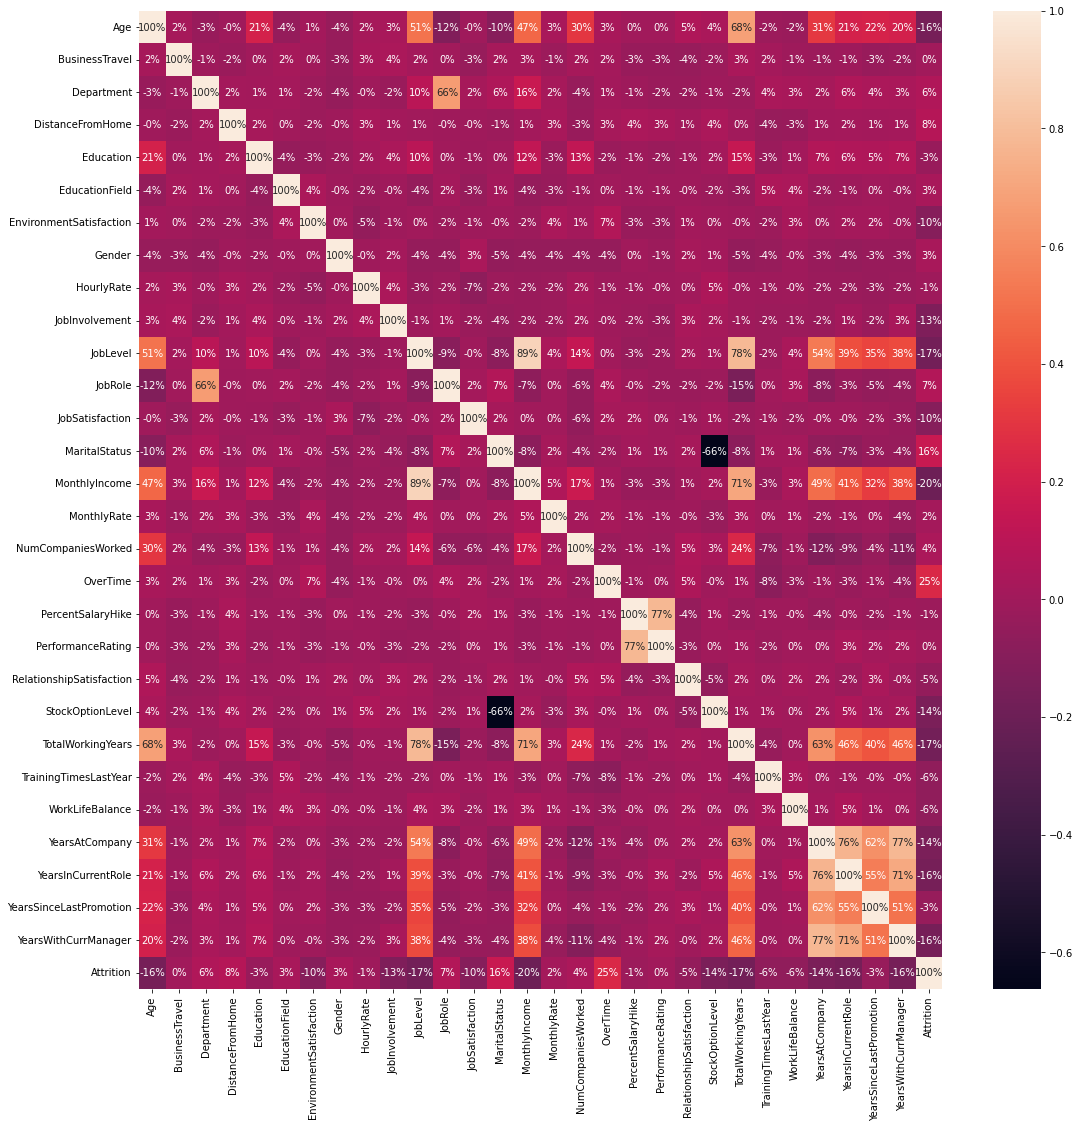

In [433]:
plt.figure(figsize=(18,18))
save_fig("matriz_correlacion")  # extra code
sns.heatmap(corr_matrix, annot=True, fmt='.0%')

Correlación de los datos con la variable "OverTime"

In [434]:
corr_matrix["OverTime"].sort_values(ascending=False)

OverTime                    1.000000
Attrition                   0.246118
EnvironmentSatisfaction     0.070132
RelationshipSatisfaction    0.048493
JobRole                     0.040662
Age                         0.028062
DistanceFromHome            0.025514
JobSatisfaction             0.024539
MonthlyRate                 0.021120
BusinessTravel              0.016543
TotalWorkingYears           0.012678
MonthlyIncome               0.009069
Department                  0.007481
PerformanceRating           0.004369
EducationField              0.002259
JobLevel                    0.000544
StockOptionLevel           -0.000449
JobInvolvement             -0.003507
PercentSalaryHike          -0.005433
HourlyRate                 -0.007782
YearsSinceLastPromotion    -0.012239
YearsAtCompany             -0.012559
MaritalStatus              -0.017521
Education                  -0.020322
NumCompaniesWorked         -0.020786
WorkLifeBalance            -0.027092
YearsInCurrentRole         -0.029758
Y

Separamos los datos de entrenamiento de las etiquetas:

In [435]:
y = employee["Attrition"]
X = employee.drop('Attrition', axis=1) #axis1 quiere decir que es una columna

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=20) #random_state -> semilla

Reducir el conjunto de datos a 2 dimensiones para visualizarlos

Text(0.5, 1.0, 'Número de observaciones por clase')

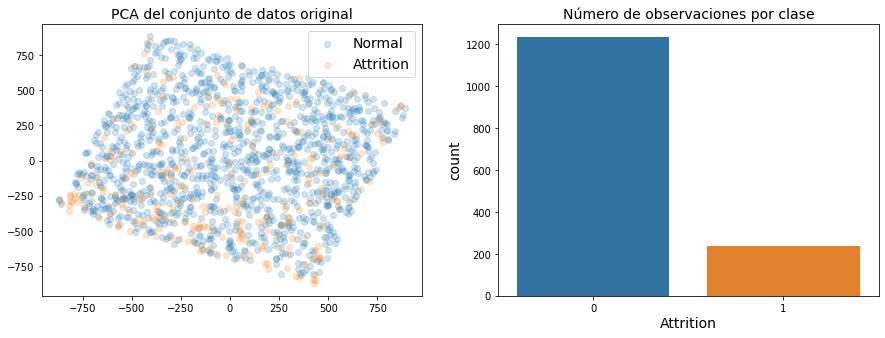

In [436]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="Normal", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="Attrition", alpha=0.2)
ax[0].set_title('PCA del conjunto de datos original')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Número de observaciones por clase')

#Técnicas de Deep learning

In [437]:
from sklearn.model_selection import train_test_split #Divisor de los datos de entrenamiento 

strat_train_set, strat_test_set = train_test_split(employee, test_size=0.2, stratify=employee["Attrition"], random_state=20) #random_state -> semilla

###Regresión logística

In [438]:
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg") #devuelve el clasificador entrenado C->regularización que impide que el método se sobreajuste, l2->distancia cuadrática, solver->minimiza el error
    clf_base.fit(X_train, y_train)
    return clf_base

###Modelo Sin Balancear

In [439]:
model = run_model(X_train, X_test, y_train, y_test)

A continuación, se define una función que muestra la matriz de confusión y un informe de clasificación:

In [440]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase prevista')
    plt.show()
    print (classification_report(y_test, pred_y))

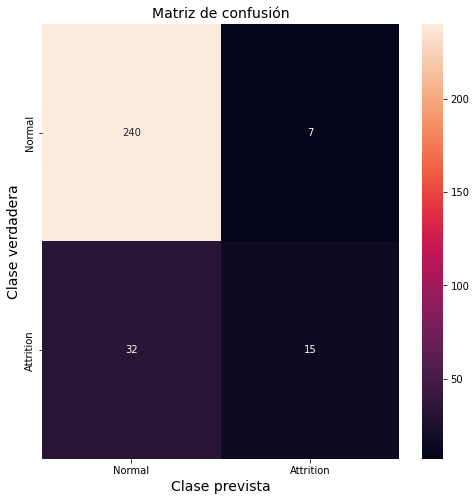

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       247
           1       0.68      0.32      0.43        47

    accuracy                           0.87       294
   macro avg       0.78      0.65      0.68       294
weighted avg       0.85      0.87      0.85       294



In [441]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Se presenta la matriz de confusión, y en particular se enfoca en la clase Attrition, que es la que se quiere detectar. Se observan 32 falsos negativos y 240 verdaderos positivos, lo que resulta en un recall de 0.32, un valor que se desea mejorar. El modelo no es capaz de detectar correctamente los casos de deserción laboral.

##Validación del balanceo de clases

1. Estrategia: Penalización para compensar



In [442]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2', random_state=1, solver="newton-cg", class_weight="balanced") #class_weight -> balancea el peso de las clases
    clf.fit(X_train, y_train)
    return clf

In [443]:
model = run_model_balanced(X_train, X_test, y_train, y_test)

Se valida el resultado

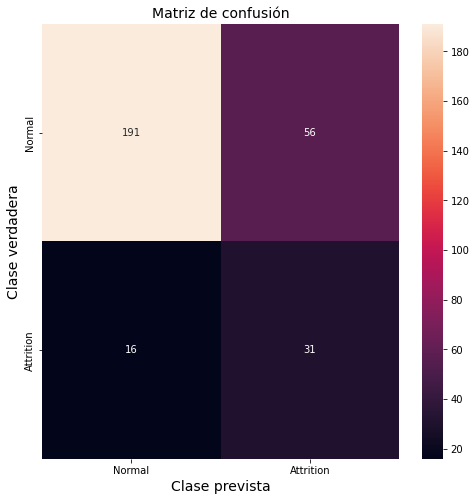

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       247
           1       0.36      0.66      0.46        47

    accuracy                           0.76       294
   macro avg       0.64      0.72      0.65       294
weighted avg       0.83      0.76      0.78       294



In [444]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Al incorporar esta modificación, se ha obtenido una significativa mejora en la detección de casos de deserción laboral. Se han acertado 32 muestras y se han fallado en 15, obteniendo un recall de 0.68.

2. Estrategia: Subsampling en la clase mayoritaria

In [445]:
us = NearMiss(sampling_strategy=0.5, n_neighbors=3, version=2) #sampling_strategy -> % al que quiero llegar distribución entre clases version->tipo de NearMiss, aquí NearMiss-2
X_train_res, y_train_res = us.fit_resample(X_train, y_train)

print ("Distribución de las etiquetas de clase antes del resampling {}".format(Counter(y_train)))
print ("Distribución de las etiquetas de clase despues del  resampling {}".format(Counter(y_train_res)))

Distribución de las etiquetas de clase antes del resampling Counter({0: 986, 1: 190})
Distribución de las etiquetas de clase despues del  resampling Counter({0: 380, 1: 190})


In [446]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

Se validan los resultados

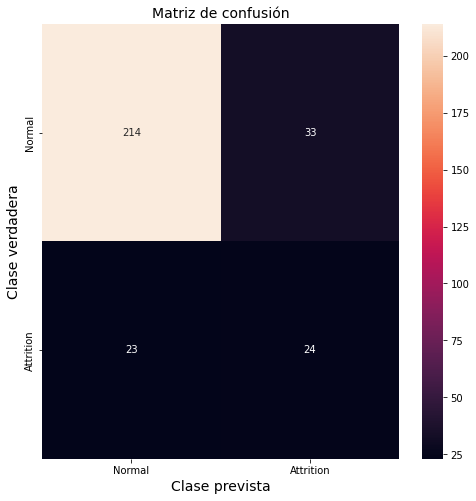

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       247
           1       0.42      0.51      0.46        47

    accuracy                           0.81       294
   macro avg       0.66      0.69      0.67       294
weighted avg       0.83      0.81      0.82       294



In [447]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Disminuyó el recall a 0.49, no representa una mejora significativa comparada con el set de datos sin balancear.

3. Estrategia: Random Oversampling de la clase minoritaria

In [448]:
os =  RandomOverSampler(sampling_strategy=0.5)
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print ("Distribución de las etiquetas de clase antes del resampling {}".format(Counter(y_train)))
print ("Distribución de las etiquetas de clase despues del  resampling {}".format(Counter(y_train_res)))

Distribución de las etiquetas de clase antes del resampling Counter({0: 986, 1: 190})
Distribución de las etiquetas de clase despues del  resampling Counter({0: 986, 1: 493})


In [449]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

Se valida el resultado

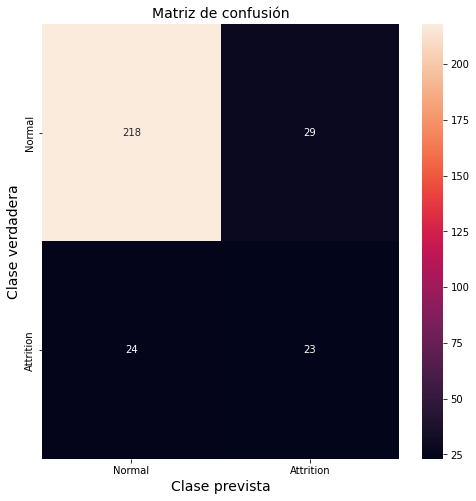

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       247
           1       0.44      0.49      0.46        47

    accuracy                           0.82       294
   macro avg       0.67      0.69      0.68       294
weighted avg       0.83      0.82      0.82       294



In [450]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Se mantiene el recall en 0.49 pero disminuyeron los falsos negativos.

4. Estrategia: Combinamos resampling con Smote-Tomek

In [451]:
os_us = SMOTETomek(sampling_strategy=0.5)
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)

print ("Distribución de las etiquetas de clase antes del resampling {}".format(Counter(y_train)))
print ("Distribución de las etiquetas de clase despues del  resampling {}".format(Counter(y_train_res)))

Distribución de las etiquetas de clase antes del resampling Counter({0: 986, 1: 190})
Distribución de las etiquetas de clase despues del  resampling Counter({0: 933, 1: 440})


In [452]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

Se evalua el resultado

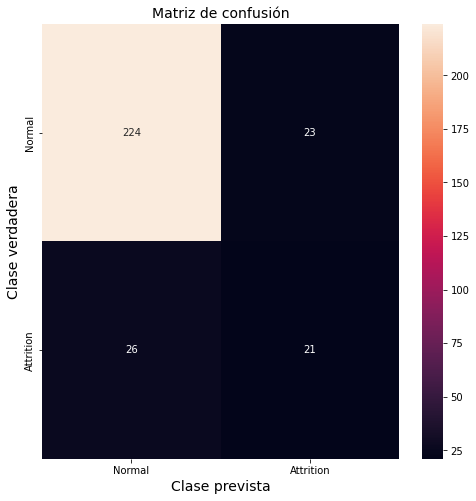

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       247
           1       0.48      0.45      0.46        47

    accuracy                           0.83       294
   macro avg       0.69      0.68      0.68       294
weighted avg       0.83      0.83      0.83       294



In [453]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Se obtiene un recall de 0.43 para la clase 2 y se observa que hay pocos falsos positivos de la clase 1, 27 de 247 muestras.

5. Estrategia: Ensamble de Modelos con Balanceo

In [454]:
from imblearn.ensemble import BalancedBaggingClassifier

# Crear un objeto del clasificador.
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(), sampling_strategy='auto',  replacement=False,random_state=0)

In [455]:
# Entrenamiento el clasificador.
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=0)

In [456]:
pred_y = bbc.predict(X_test)

Se evalua el resultado

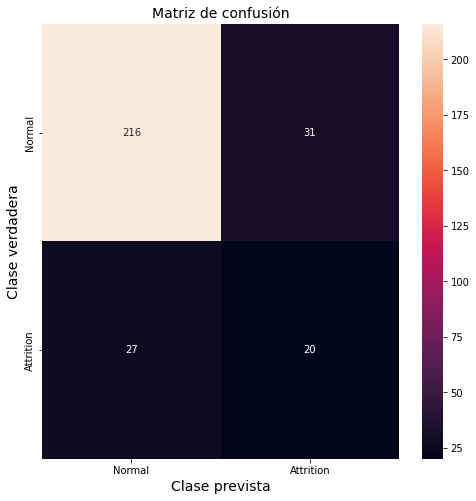

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       247
           1       0.39      0.43      0.41        47

    accuracy                           0.80       294
   macro avg       0.64      0.65      0.64       294
weighted avg       0.81      0.80      0.81       294



In [457]:
mostrar_resultados(y_test, pred_y)

Se evaluará su rendimiento y se observa una mejora en comparación con el modelo inicial, con un recall de 0.51 para los casos de deserción laboral.

En cuanto a los resultados obtenidos, se presentan en una tabla ordenada de mejor a peor. 

In [458]:
df = pd.DataFrame({'algorithm' : ['Regresion Logística', 'Penalización', 'NearMiss Subsampling', 
                                  'Random Oversampling', 'Smote Tomek', 'Ensemble'],
                   'precision' : [0.88, 0.93, 0.90, 0.91, 0.90, 0.90],
                   'recall' : [0.32, 0.68, 0.49, 0.53, 0.45, 0.51]})

df['overall'] = df.apply(lambda row: (row.precision + row.recall)/2, axis=1)

df = df.sort_values(['overall'], ascending=False)
df

,algorithm,precision,recall,overall
1,Penalización,0.93,0.68,0.805
3,Random Oversampling,0.91,0.53,0.720
5,Ensemble,0.90,0.51,0.705
2,NearMiss Subsampling,0.90,0.49,0.695
4,Smote Tomek,0.90,0.45,0.675
0,Regresion Logística,0.88,0.32,0.600


La estrategia con la que se obtiene mejor resultado es la Penalización con una precision del 0.93 y un recall del 0.68, lo que indica que es capaz de clasificar correctamente tanto las instancias positivas como las negativas de la clase minoritaria.
El modelo 3 obtuvo una precision parecida sin embargo fué mucho menor el recall con respecto al modelo 1.
Los modelos 4, 2 y 5 mantuvieron una presición del 0.9 sin embargo el recall iba disminuyendo, sin embargo, es importante destacar que todas las técnicas aplicadas logran mejorar el modelo inicial de Regresión Logística, que solo alcanzaba un 0.32 de recall para la clase de Attrition (deserción laboral). Cabe recordar que el conjunto de datos presenta un desbalanceo considerable entre las clases.



##Grid search

In [459]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [460]:
grid=[i for i in range(-5,7,1)]
param_grid={'C':[2**i for i in grid], 'gamma':[2**(0.5*i) for i in grid]}

In [461]:
param_grid['C']

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]

In [462]:
param_grid['gamma']

[0.1767766952966369,
 0.25,
 0.3535533905932738,
 0.5,
 0.7071067811865476,
 1.0,
 1.4142135623730951,
 2.0,
 2.8284271247461903,
 4.0,
 5.656854249492381,
 8.0]

In [463]:
clf=GridSearchCV(SVC(kernel='rbf'),param_grid=param_grid,n_jobs=-1,verbose=2)  #GridSearchCV(modelo,grilla,paralelizar,regularización)

In [464]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64],
                         'gamma': [0.1767766952966369, 0.25, 0.3535533905932738,
                                   0.5, 0.7071067811865476, 1.0,
                                   1.4142135623730951, 2.0, 2.8284271247461903,
                                   4.0, 5.656854249492381, 8.0]},
             verbose=2)

In [465]:
import pandas as pd

cv_results=pd.DataFrame(clf.cv_results_)

In [466]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.122051,0.005180,0.041693,0.001161,0.03125,0.176777,"{'C': 0.03125, 'gamma': 0.1767766952966369}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1
1,0.121488,0.004768,0.046718,0.011922,0.03125,0.25,"{'C': 0.03125, 'gamma': 0.25}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1
2,0.117349,0.001793,0.039856,0.001215,0.03125,0.353553,"{'C': 0.03125, 'gamma': 0.3535533905932738}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1
3,0.123794,0.008591,0.039960,0.000739,0.03125,0.5,"{'C': 0.03125, 'gamma': 0.5}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1
4,0.116931,0.000720,0.039616,0.000571,0.03125,0.707107,"{'C': 0.03125, 'gamma': 0.7071067811865476}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.149033,0.009320,0.040087,0.001409,64,2.0,"{'C': 64, 'gamma': 2.0}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1
140,0.143222,0.001106,0.039859,0.000962,64,2.828427,"{'C': 64, 'gamma': 2.8284271247461903}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1
141,0.148282,0.007036,0.040803,0.003530,64,4.0,"{'C': 64, 'gamma': 4.0}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1
142,0.145337,0.001505,0.041366,0.001333,64,5.656854,"{'C': 64, 'gamma': 5.656854249492381}",0.838983,0.838298,0.838298,0.838298,0.838298,0.838435,0.000274,1


In [467]:
print(len(cv_results))
print(len(param_grid['C']))
print(len(param_grid['gamma']))
total=len(param_grid['C'])*len(param_grid['gamma'])
print(total)

144
12
12
144


In [468]:
scores=clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']),len(param_grid['gamma']))

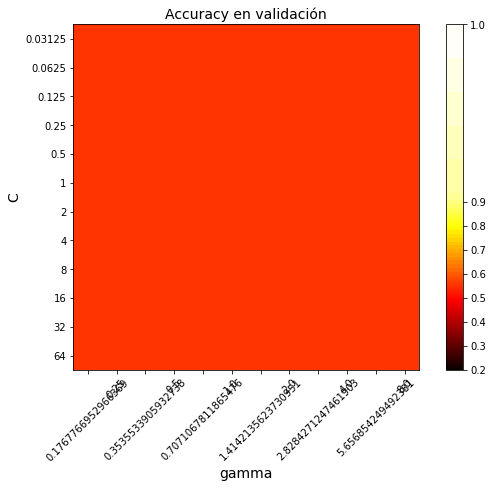

In [469]:
plt.figure(figsize=(10, 6))  #entre más claro mejor el resultado de la búsqueda de grillas
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92, vmax=1.))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Accuracy en validación')
plt.show()

In [470]:
clf.best_params_

{'C': 0.03125, 'gamma': 0.1767766952966369}

In [471]:
clf.best_score_

0.838434908041832

In [472]:
cv_bestresults=cv_results[['param_C','param_gamma','mean_test_score']]

In [473]:
cv_bestresults.head()

,param_C,param_gamma,mean_test_score
0,0.03125,0.176777,0.838435
1,0.03125,0.25,0.838435
2,0.03125,0.353553,0.838435
3,0.03125,0.5,0.838435
4,0.03125,0.707107,0.838435


In [474]:
cv_bestresults.sort_values(by='mean_test_score', ascending=False) #en orden top de los resultados

,param_C,param_gamma,mean_test_score
0,0.03125,0.176777,0.838435
1,0.03125,0.25,0.838435
92,4,2.828427,0.838435
93,4,4.0,0.838435
94,4,5.656854,0.838435
...,...,...,...
48,0.5,0.176777,0.838435
49,0.5,0.25,0.838435
50,0.5,0.353553,0.838435
51,0.5,0.5,0.838435


In [475]:
clf.best_score_

0.838434908041832

In [476]:
clf.best_params_

{'C': 0.03125, 'gamma': 0.1767766952966369}

In [477]:
clf.score(X_test,y_test)

0.8401360544217688

#Otros modelos

##RandomForest

In [478]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform  #para el %
from scipy.stats import randint  #para la lista de árboles
from time import time

In [479]:
clf = RandomForestClassifier()

param_dist = {"n_estimators": randint(4, 800),
              "max_features": uniform()}

In [480]:
n_iter_search = 20 #número de elementos donde va realizar la búsqueda aleatoria (configuraciones de escogencias aleatorias)
#búsqueda aleatoria
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                                   n_iter=n_iter_search, cv=5, #cv -> pliegues
                                   n_jobs=-1, verbose=2)

In [481]:
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV tomó {} segundos usando {} configuraciones".format(time() - start,
                                                                               n_iter_search))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV tomó 159.40621781349182 segundos usando 20 configuraciones


In [482]:
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results[['param_n_estimators','param_max_features','mean_test_score']]
cv_results.sort_values(by='mean_test_score',ascending=False).head()

,param_n_estimators,param_max_features,mean_test_score
9,190,0.183448,0.861406
8,157,0.590843,0.859704
16,563,0.513001,0.857999
15,249,0.08118,0.857155
18,700,0.467039,0.857144


In [483]:
random_search.best_params_

{'max_features': 0.18344759711031033, 'n_estimators': 190}

In [484]:
random_search.best_score_

0.86140641904075

In [485]:
random_search.score(X_test, y_test)

0.8605442176870748

In [486]:
clf = RandomForestClassifier(n_estimators=417, max_features=0.20372223995178984)

clf.fit(X_train, y_train);

In [487]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Importancia de características:")

for f in range(X_train.shape[1]):
    print("Característica %s (%f)" % (X_train.columns[indices[f]], importances[indices[f]]))

Importancia de características:
Característica MonthlyIncome (0.081763)
Característica Age (0.067264)
Característica MonthlyRate (0.057855)
Característica TotalWorkingYears (0.057455)
Característica OverTime (0.054719)
Característica DistanceFromHome (0.054043)
Característica HourlyRate (0.050000)
Característica YearsAtCompany (0.045194)
Característica PercentSalaryHike (0.038194)
Característica NumCompaniesWorked (0.036969)
Característica YearsWithCurrManager (0.035717)
Característica EnvironmentSatisfaction (0.032996)
Característica JobSatisfaction (0.032215)
Característica JobRole (0.031697)
Característica JobInvolvement (0.029041)
Característica StockOptionLevel (0.028827)
Característica TrainingTimesLastYear (0.027743)
Característica YearsSinceLastPromotion (0.025841)
Característica YearsInCurrentRole (0.025634)
Característica WorkLifeBalance (0.025459)
Característica RelationshipSatisfaction (0.024879)
Característica EducationField (0.024617)
Característica MaritalStatus (0.02332

##K-Means

In [488]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [489]:
cols = X.columns
ms = MinMaxScaler()
X_normalized = ms.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=[cols])

Método del codo elbow para encontrar el número optimo de grupos

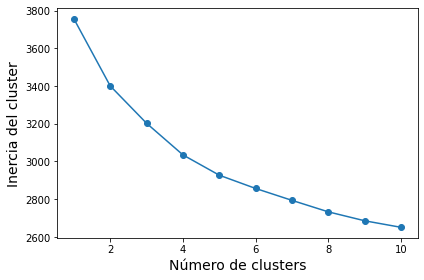

In [490]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                tol=1e-04,
                random_state=0)
    km.fit(X_normalized)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia del cluster')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

In [491]:
print('Inercia del cluster: %.2f' % km.inertia_)

Inercia del cluster: 2650.60


De la gráfica anterior se puede apreciar que para k=2 hay una buena opción de agrupamiento de datos

En el siguiente gráfico generamos los coeficientes de silueta para un agrupamiento de k-means con k=2

In [492]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X_normalized)

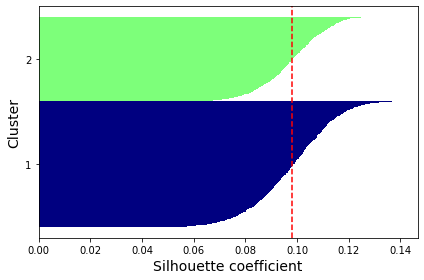

In [493]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_normalized, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette_bad.png', dpi=300)
plt.show()

In [494]:
k_means = KMeans(n_clusters=2, random_state=0)
y_k_means = k_means.fit_predict(X_normalized)
labels = k_means.labels_
# comprobar cuántas de las muestras estan correctamente etiquetadas
correct_labels = sum(y == labels)
print("Resultado: %d de %d muestras se etiquetaron correctamente." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f} %'.format((correct_labels *100)/ float(y.size)))

Resultado: 819 de 1470 muestras se etiquetaron correctamente.
Accuracy score: 55.71 %


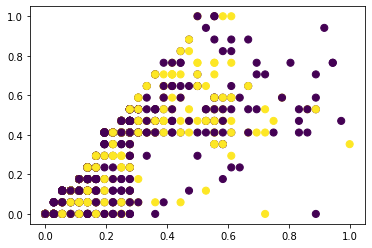

In [495]:
plt.scatter(X_normalized['YearsAtCompany'],X_normalized['YearsWithCurrManager'], c=labels, s=50, cmap='viridis');

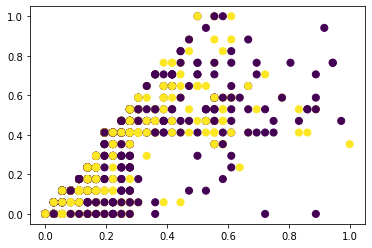

In [496]:
from sklearn.cluster import SpectralClustering #libreria basada en grafos
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', 
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X_normalized['YearsAtCompany'],X_normalized['YearsWithCurrManager'], c=labels, s=50, cmap='viridis');

In [497]:
# comprobar cuántas de las muestras estan correctamente etiquetadas
correct_labels = sum(y == labels)
print("Resultado: %d de %d muestras se etiquetaron correctamente." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f} %'.format((correct_labels *100)/ float(y.size)))

Resultado: 771 de 1470 muestras se etiquetaron correctamente.
Accuracy score: 52.45 %


No se obseva una mejora al utlizar SpectralClustering pasando del 44.29% del KMeans al 51.90%, sin embargo no es una medida adecuada de clasificicón del conjunto de datos.

##Reducción de dimensionalidad

In [498]:
# Importamos el paquete PCA de scikit-learn
from sklearn.decomposition import PCA

# Creamos una instancia de PCA con dos componentes
pca = PCA(n_components=2)
# Ajustamos la instancia de PCA con los datos X
pca.fit(X)

# Imprimimos los componentes calculados por scikit-learn
print("sklearn PCA components")
print(pca.components_)

sklearn PCA components
[[ 4.14384740e-03 -6.97415213e-06  9.66546679e-05  5.88080040e-04
   4.73309084e-05 -1.26411276e-04  7.70425709e-05 -6.32086534e-05
  -1.01064029e-03 -4.02377325e-05  9.13972597e-04 -1.11724382e-04
   3.06822955e-06 -7.71893044e-06  3.68000460e-01  9.29797794e-01
   4.40920196e-04  2.44442357e-05 -1.37020825e-04 -1.55303745e-05
  -4.16244419e-06 -4.82358896e-05  4.98789721e-03 -2.70482853e-05
   3.30933667e-05  2.12515135e-03  1.11523169e-03  8.73739753e-04
   8.22703628e-04]
 [ 1.02952187e-02  5.04945916e-05  1.90379469e-04  1.87049958e-06
   3.39258522e-04 -1.08352522e-04 -8.28752508e-05 -3.19083152e-05
  -6.66213803e-04 -2.86676156e-05  2.37375459e-03 -4.22418529e-04
   4.96845566e-06 -1.55085264e-04  9.29597320e-01 -3.68068280e-01
   9.65947981e-04  2.39466601e-07 -2.28296221e-04 -1.96985036e-05
   1.94003908e-05  7.86612646e-05  1.32119373e-02 -9.15848471e-05
   5.33492411e-05  7.40781979e-03  3.65332096e-03  2.55650004e-03
   3.43500048e-03]]


In [499]:
X.shape

(1470, 29)

In [500]:
%timeit pca.fit(X)

60.5 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


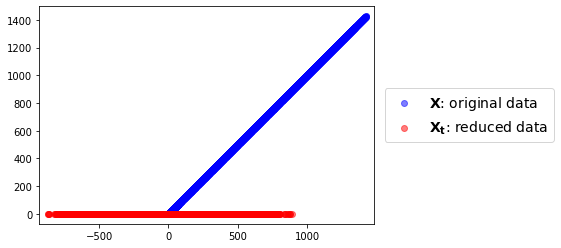

In [501]:
# Creamos un objeto PCA con 1 componente para reducir la dimensionalidad de los datos de X a 1D
pca = PCA(n_components=1)

# Ajustamos el modelo PCA a los datos X
pca.fit(X)

# Transformamos los datos X al espacio reducido con PCA
Xt = pca.transform(X)[:,0]

# Graficamos los datos originales X en azul y los datos transformados Xt en rojo en el eje horizontal
# El eje vertical está fijado en 0 para visualizar mejor la reducción de dimensionalidad
plt.scatter(X, X, color="blue", alpha=.5, label="$\mathbf{X}$: original data")
plt.scatter(Xt, [0]*len(Xt), color="red", alpha=.5, label="$\mathbf{X_t}$: reduced data")

# Establecemos el mismo rango en ambos ejes para una mejor visualización y agregamos una leyenda
plt.axis("equal");
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

Clasificador Naive Bayes y calcula el desempeño de la clasificación en los datos originales y los datos transformados por PCA

In [502]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

pca = PCA(n_components=29)
Xp = pca.fit_transform(X)

print(np.mean(cross_val_score(GaussianNB(), X, y, cv=5)))
print(np.mean(cross_val_score(GaussianNB(), Xp, y, cv=5)))

0.8020408163265307
0.8680272108843538


El segundo modelo, el que utilizó PCA, tiene un mejor rendimiento en términos de precisión que el primero que no utilizó PCA.

###Singular Value Decomposition (SVD)

In [503]:
U, s, V = np.linalg.svd(X)

In [504]:
U.shape, s.shape, V.shape

((1470, 1470), (29,), (29, 29))

Reconstruimos la matriz diagonal s

In [505]:
# Convertir el vector de valores singulares en una matriz diagonal
s = np.diag(s)
# Añadir filas de ceros a la matriz de valores singulares para que tenga la misma forma que U
s = np.vstack([s, np.zeros((U.shape[0]-s.shape[0], s.shape[1]))])

Verificamos las propiedades SVD

In [506]:
print("verificando si U es unitaria: ", np.allclose(U.dot(U.T), np.eye(U.shape[0])))
print("verificando si las filas de U son unitarias: ", np.allclose(np.linalg.norm(U, axis=1), np.ones(U.shape[0])))
print("verificando si las columnas de U son unitarias: ", np.allclose(np.linalg.norm(U, axis=0), np.ones(U.shape[1])))
print("verificando si V es unitaria: ", np.allclose(V.T.dot(V), np.eye(V.shape[0])))
print("verificando si las filas de V son unitarias: ", np.allclose(np.linalg.norm(V, axis=1), np.ones(V.shape[0])))
print("verificando si las columnas de V son unitarias: ", np.allclose(np.linalg.norm(V, axis=0), np.ones(V.shape[1])))
print("verificando la reconstrucción de X: ", np.allclose(U.dot(s).dot(V), X))

verificando si U es unitaria:  True
verificando si las filas de U son unitarias:  True
verificando si las columnas de U son unitarias:  True
verificando si V es unitaria:  True
verificando si las filas de V son unitarias:  True
verificando si las columnas de V son unitarias:  True
verificando la reconstrucción de X:  True


Text(0, 0.5, 'component value')

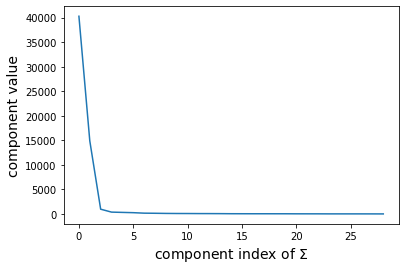

In [507]:
plt.plot(np.diagonal(s))
plt.xlabel("component index of $\Sigma$");
plt.ylabel("component value")

In [508]:
Xm = X-np.mean(X, axis=0)
U,s,V = np.linalg.svd(Xm)
pca = PCA(n_components=29)
pca.fit(Xm);

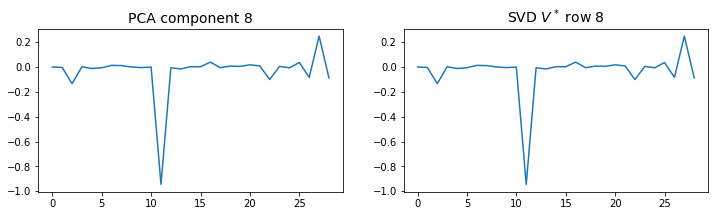

In [509]:
i = np.random.randint(pca.n_components)
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(pca.components_[i])
plt.title("PCA component %d"%i)
plt.subplot(122)
plt.title("SVD $V^*$ row %d"%i)
plt.plot(V[i])

In [510]:
n_components = np.argwhere(np.cumsum(s)/np.sum(s)>.4)[0][0]
print("Keeping %d components"%n_components)

Keeping 0 components
